# Customer/Market Analyst DIVE Analysis - Retail Chain Transformation

This Colab notebook imports the **SuperMarketSynth** table from **BigQuery** once at the top, then executes a detailed DIVE analysis (Discover → Investigate → Validate → Extend).

**Notes**
- Use the first section to authenticate and load data from BigQuery.
- All visualizations rely on **matplotlib** only (no seaborn/styles).
- You can tune parameters like the high‑value threshold (e.g., 80th percentile).


## Data Import (Run first)
Authenticate and bring the BigQuery table into a pandas `DataFrame` named `df`.
Edit the `PROJECT_ID`, `DATASET`, and `TABLE` to match your environment.

In [1]:
!pip install pandas pandas-gbq plotly

In [2]:
# Authenticate (Colab)
from google.colab import auth
auth.authenticate_user()

In [3]:
import pandas as pd
import pandas_gbq

project_id = "mgmt599-final-project-468615"
table_id = "superstore.SuperMarketSynth"

query = f"SELECT * FROM `{project_id}.{table_id}`"

df = pandas_gbq.read_gbq(query, project_id=project_id, dialect="standard")

Downloading: 100%|██████████|


In [4]:
display(df.head())

,Invoice ID,Branch,City,Customer type,Gender,Product line,Unit price,Quantity,Tax 5%,Sales,Date,Time,Payment,cogs,gross margin percentage,gross income,Rating,Month
0,556-97-7101,Giza,Naypyitaw,Normal,Female,Electronic accessories,63.22,2,6.3220,132.7620,2019-01-01,3:51:00 PM,Cash,126.44,4.761905,6.3220,8.5,None
1,891-01-7034,Cairo,Mandalay,Normal,Female,Electronic accessories,74.71,6,22.4130,470.6730,2019-01-01,7:07:00 PM,Cash,448.26,4.761905,22.4130,6.7,None
2,416-17-9926,Alex,Yangon,Member,Female,Electronic accessories,74.22,10,37.1100,779.3100,2019-01-01,2:42:00 PM,Credit card,742.20,4.761905,37.1100,4.3,None
3,744-09-5786,Cairo,Mandalay,Normal,Male,Electronic accessories,22.01,6,6.6030,138.6630,2019-01-02,6:50:00 PM,Cash,132.06,4.761905,6.6030,7.6,None
4,279-74-2924,Cairo,Mandalay,Member,Male,Electronic accessories,72.17,1,3.6085,75.7785,2019-01-04,7:40:00 PM,Cash,72.17,4.761905,3.6085,6.1,None


In [5]:
# Quick checks
import pandas as pd, numpy as np
df.head(), df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 18 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   Invoice ID               100000 non-null  object        
 1   Branch                   100000 non-null  object        
 2   City                     100000 non-null  object        
 3   Customer type            100000 non-null  object        
 4   Gender                   100000 non-null  object        
 5   Product line             100000 non-null  object        
 6   Unit price               100000 non-null  float64       
 7   Quantity                 100000 non-null  Int64         
 8   Tax 5%                   100000 non-null  float64       
 9   Sales                    100000 non-null  float64       
 10  Date                     100000 non-null  datetime64[us]
 11  Time                     100000 non-null  object        
 12  Payment          

(    Invoice ID Branch       City Customer type  Gender  \
 0  556-97-7101   Giza  Naypyitaw        Normal  Female   
 1  891-01-7034  Cairo   Mandalay        Normal  Female   
 2  416-17-9926   Alex     Yangon        Member  Female   
 3  744-09-5786  Cairo   Mandalay        Normal    Male   
 4  279-74-2924  Cairo   Mandalay        Member    Male   
 
              Product line  Unit price  Quantity   Tax 5%     Sales       Date  \
 0  Electronic accessories       63.22         2   6.3220  132.7620 2019-01-01   
 1  Electronic accessories       74.71         6  22.4130  470.6730 2019-01-01   
 2  Electronic accessories       74.22        10  37.1100  779.3100 2019-01-01   
 3  Electronic accessories       22.01         6   6.6030  138.6630 2019-01-02   
 4  Electronic accessories       72.17         1   3.6085   75.7785 2019-01-04   
 
          Time      Payment    cogs  gross margin percentage  gross income  \
 0  3:51:00 PM         Cash  126.44                 4.761905        6.32

## Common Setup
Utilities, feature engineering, and helper plotting functions used across D/I/V/E.

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# Defensive copy
df = df.copy()

# Parse Date/Time fields and derive features
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
df['Time_dt'] = pd.to_datetime(df['Time'], format='%I:%M:%S %p', errors='coerce')
df['Hour'] = df['Time_dt'].dt.hour

def time_bucket(h):
    if pd.isna(h): return 'Unknown'
    if 6 <= h < 12: return 'Morning'
    if 12 <= h < 17: return 'Afternoon'
    if 17 <= h < 21: return 'Evening'
    return 'Late'

df['Time_of_day'] = df['Hour'].apply(time_bucket)
df['Day_of_week'] = df['Date'].dt.day_name()
df['Month']       = df['Date'].dt.month_name()

# High-value threshold
HV_Q = 0.80
hv_threshold = df['Sales'].quantile(HV_Q)
df['High_value'] = df['Sales'] >= hv_threshold

COL_SALES, COL_GI, COL_RTG = 'Sales', 'gross income', 'Rating'

def seg_metrics(grouped):
    out = grouped.agg(
        transactions   = (COL_SALES, 'size'),
        total_sales    = (COL_SALES, 'sum'),
        avg_sales      = (COL_SALES, 'mean'),
        total_gi       = (COL_GI, 'sum'),
        avg_gi         = (COL_GI, 'mean'),
        avg_rating     = (COL_RTG, 'mean'),
        hv_count       = ('High_value', 'sum')
    ).reset_index()
    out['pct_high_value'] = out['hv_count'] / out['transactions']
    return out.drop(columns=['hv_count'])

def bar_from_series(s, title, xlabel='', ylabel='value', rot=45):
    plt.figure(figsize=(9,4))
    s.sort_values(ascending=False).plot(kind='bar')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xticks(rotation=rot)
    plt.tight_layout()
    plt.show()

def heatmap_from_pivot(piv, title, xlabel='', ylabel=''):
    plt.figure(figsize=(9,4))
    im = plt.imshow(piv.values, aspect='auto')
    plt.colorbar(im, fraction=0.046, pad=0.04)
    plt.xticks(range(piv.shape[1]), piv.columns, rotation=45, ha='right')
    plt.yticks(range(piv.shape[0]), piv.index)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    # annotate
    for i in range(piv.shape[0]):
        for j in range(piv.shape[1]):
            plt.text(j, i, f"{piv.values[i, j]:.2f}", ha='center', va='center', fontsize=8)
    plt.tight_layout()
    plt.show()


## Discover Phase
### Gemini Prompt:
"I'm analyzing **customer segments and purchasing behavior** for a legacy retail chain losing market share.
Provide the code to generate the below:



* **D1 – Segment Prioritization (Customer type × Gender)**

  * Matrix: avg\_sales, avg\_gi, pct\_high\_value, avg\_rating, transactions, total\_sales
  * Plots: bar(Avg Sales/Txn), bar(Avg GI/Txn), bar(% High-Value)

* **D2 – Product Popularity vs Margin (Product line)**

  * Matrix: sales\_share, avg\_gi, avg\_qty\_per\_txn, avg\_rating, transactions, total\_sales
  * Plots: bar(Sales Share by Product line), bar(Avg GI/Txn), bar(Avg Units/Txn)

* **D3 – City/Branch Attractiveness (City × Branch)**

  * Matrix: avg\_sales, avg\_gi, pct\_high\_value, avg\_rating, transactions, total\_sales
  * Plots: bar(Avg Sales/Txn), bar(% High-Value)

* **D4 – Payment Adoption (mix)**

  * Matrices: payment mix by Gender; payment mix by Customer type
  * Plots: stacked bar(Payment Mix by Gender), stacked bar(Payment Mix by Customer type)

* **D5 – Time-of-Day Opportunity**

  * Matrix: avg\_sales, avg\_gi, avg\_rating, transactions, total\_sales (by Time\_of\_day)
  * Plots: bar(Total Sales by Time of day), bar(Avg Rating by Time of day)

* **D6 – Day-of-Week Cadence**

  * Matrix: avg\_sales, avg\_gi, avg\_rating, transactions, total\_sales (by Day\_of\_week)
  * Plots: bar(Total Sales by Day), bar(Avg Rating by Day)

* **D7 – Product line × Gender Performance**

  * Matrix: avg\_sales, avg\_gi, avg\_qty, avg\_rating, txns (by Product line × Gender)
  * Plots: heatmap(Avg Sales/Txn), heatmap(Avg GI/Txn)

* **D8 – Customer type × Time\_of\_day**

  * Matrix: avg\_sales, avg\_rating, pct\_hv, txns
  * Plots: heatmap(Avg Sales/Txn), heatmap(% High-Value)

* **D9 – Payment Performance Matrix**

  * Matrix: avg\_sales, avg\_rating, pct\_hv, txns (by Payment)
  * Plots: bar(Avg Sales/Txn), bar(Avg Rating), bar(% High-Value)

#### D1) Segment Prioritization — Customer type × Gender

,Customer type,Gender,transactions,total_sales,avg_sales,total_gi,avg_gi,avg_rating,pct_high_value
0,Member,Female,32380,571886.025098,17.661706,97252.557809,3.003476,6.981481,0.201143
1,Member,Male,24187,402327.953738,16.634058,71925.601247,2.973730,6.970533,0.202712
2,Normal,Female,24677,410735.107216,16.644451,72857.484378,2.952445,6.965660,0.196823
3,Normal,Male,18756,322936.626072,17.217777,55941.407448,2.982587,6.991831,0.198710


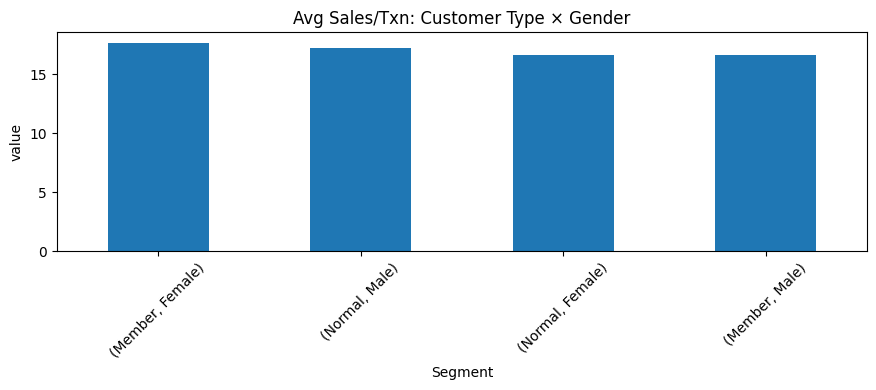

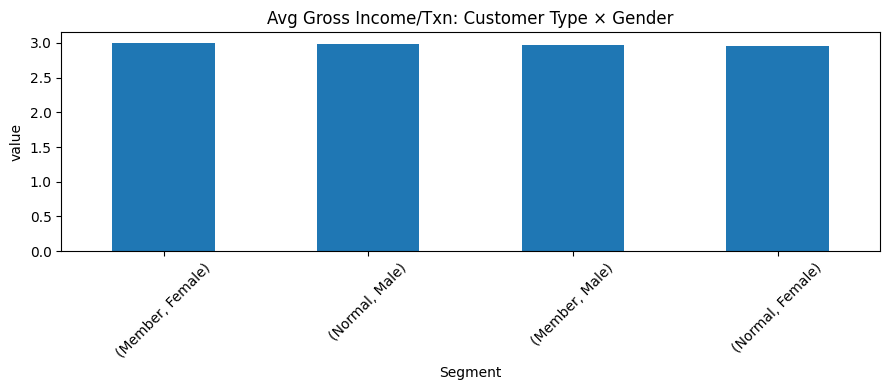

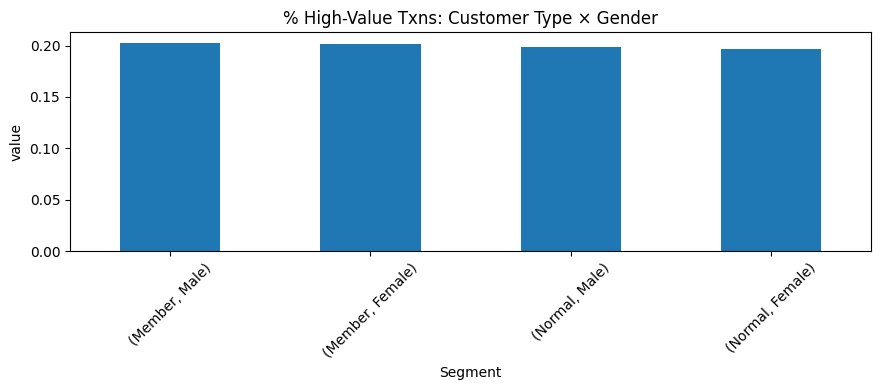

In [7]:
d1 = seg_metrics(df.groupby(['Customer type','Gender']))
display(d1)
bar_from_series(d1.set_index(['Customer type','Gender'])['avg_sales'], 'Avg Sales/Txn: Customer Type × Gender', 'Segment')
bar_from_series(d1.set_index(['Customer type','Gender'])['avg_gi'], 'Avg Gross Income/Txn: Customer Type × Gender', 'Segment')
bar_from_series(d1.set_index(['Customer type','Gender'])['pct_high_value'], '% High-Value Txns: Customer Type × Gender', 'Segment')

#### D2) Product Popularity vs Margin — Product line

,Product line,transactions,total_sales,avg_sales,total_gi,avg_gi,avg_rating,pct_high_value,sales_share,avg_qty_per_txn
0,Electronic accessories,17031,290714.454555,17.069723,50930.919636,2.990483,6.959868,0.199812,0.170219,1.954201
1,Fashion accessories,17712,299172.509168,16.890950,52454.785877,2.961539,6.969063,0.199243,0.175171,1.944388
2,Food and beverages,17439,296817.146897,17.020308,51806.516713,2.970727,6.975943,0.201273,0.173792,1.948105
3,Health and beauty,15210,259430.306068,17.056562,45298.323041,2.978193,6.976229,0.196976,0.151901,1.952794
4,Home and lifestyle,16046,276797.980207,17.250279,48023.017579,2.992834,6.982321,0.201608,0.162071,1.955815
5,Sports and travel,16562,284953.315229,17.205248,49463.488036,2.986565,6.998988,0.200882,0.166846,1.951817


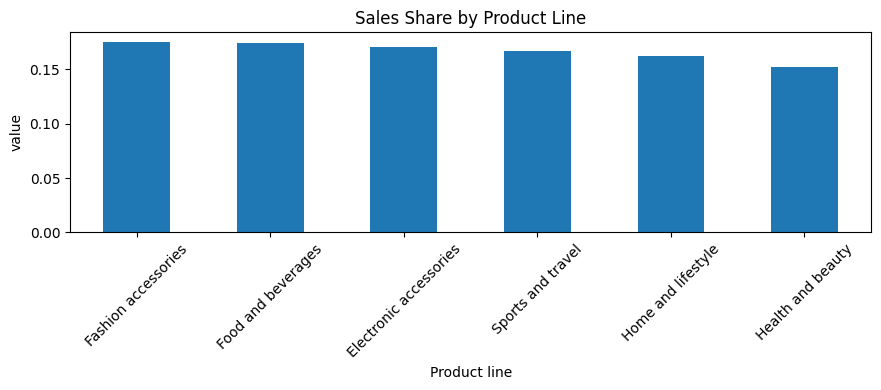

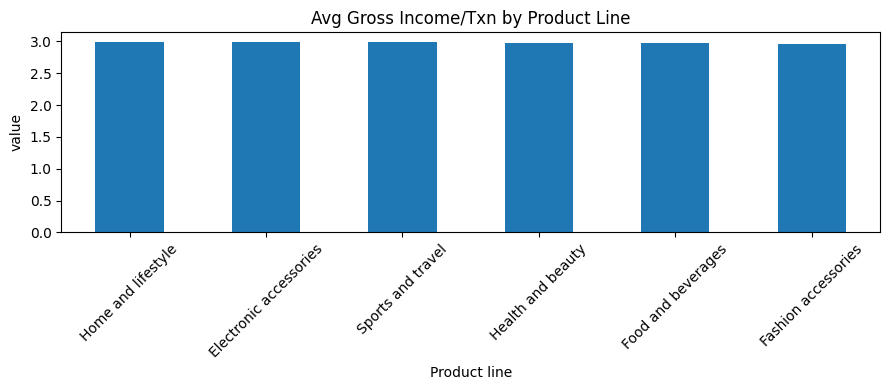

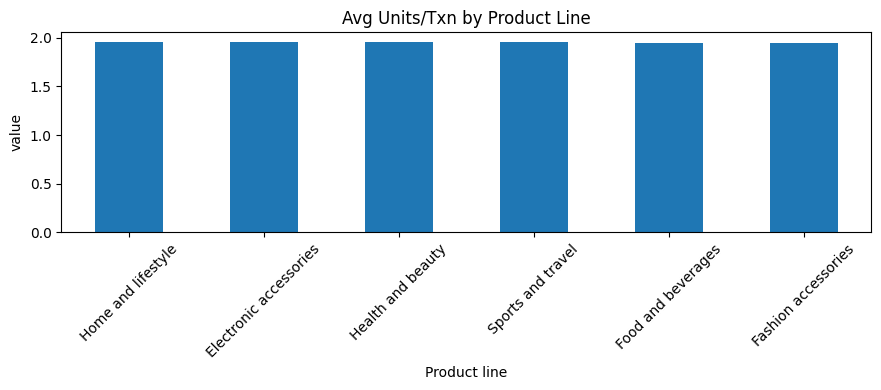

In [8]:
d2 = seg_metrics(df.groupby(['Product line']))
d2['sales_share'] = d2['total_sales'] / d2['total_sales'].sum()
qty_avg = df.groupby('Product line')['Quantity'].mean().rename('avg_qty_per_txn')
d2 = d2.merge(qty_avg, on='Product line', how='left')
display(d2)
bar_from_series(d2.set_index('Product line')['sales_share'], 'Sales Share by Product Line', 'Product line')
bar_from_series(d2.set_index('Product line')['avg_gi'], 'Avg Gross Income/Txn by Product Line', 'Product line')
bar_from_series(d2.set_index('Product line')['avg_qty_per_txn'], 'Avg Units/Txn by Product Line', 'Product line')

#### D3) City/Branch Attractiveness — City × Branch

,City,Branch,transactions,total_sales,avg_sales,total_gi,avg_gi,avg_rating,pct_high_value
0,Mandalay,Alex,11191,155724.286482,13.915136,31848.616334,2.845913,6.994717,0.187293
1,Mandalay,Cairo,11208,257839.876594,23.004985,36057.449875,3.217117,6.969413,0.214757
2,Mandalay,Giza,10757,149576.334070,13.905023,30487.029691,2.834157,6.967242,0.188993
3,Naypyitaw,Alex,11130,156896.346151,14.096707,32107.776177,2.884796,6.953231,0.198113
4,Naypyitaw,Cairo,10761,151556.484706,14.083866,30856.214982,2.867411,6.984207,0.194870
5,Naypyitaw,Giza,10986,261139.492736,23.770207,35978.329129,3.274925,6.980992,0.218005
6,Yangon,Alex,11592,263192.976075,22.704708,36977.536822,3.189919,6.973233,0.213423
7,Yangon,Cairo,11251,157554.255274,14.003578,32128.867378,2.855645,6.988244,0.194649
8,Yangon,Giza,11124,154405.660036,13.880408,31535.230493,2.834882,6.980511,0.189051


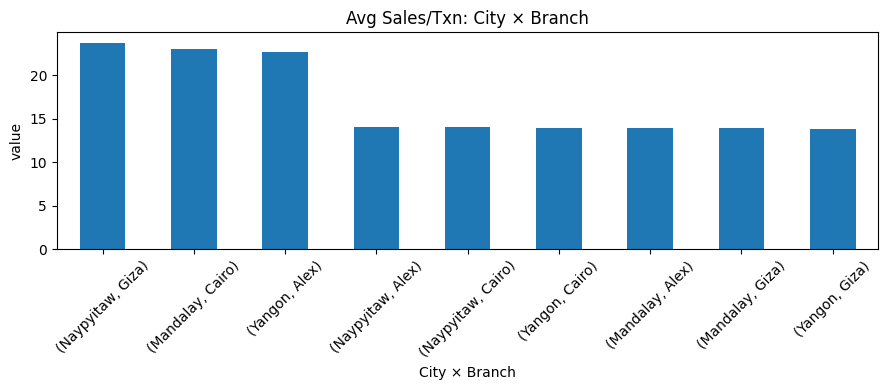

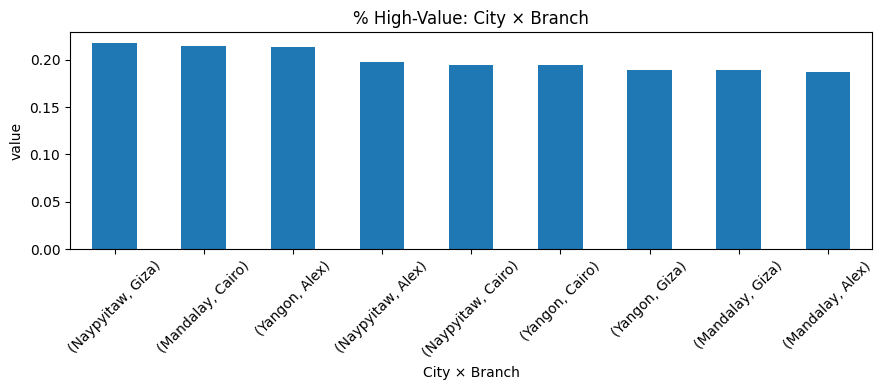

In [9]:
d3 = seg_metrics(df.groupby(['City','Branch']))
display(d3)
bar_from_series(d3.set_index(['City','Branch'])['avg_sales'], 'Avg Sales/Txn: City × Branch', 'City × Branch')
bar_from_series(d3.set_index(['City','Branch'])['pct_high_value'], '% High-Value: City × Branch', 'City × Branch')

#### D4) Payment Adoption — Mix by Gender and Customer type

Payment,Cash,Credit card,Ewallet
Gender,,,
Female,0.345058,0.310041,0.344901
Male,0.339497,0.311273,0.349230


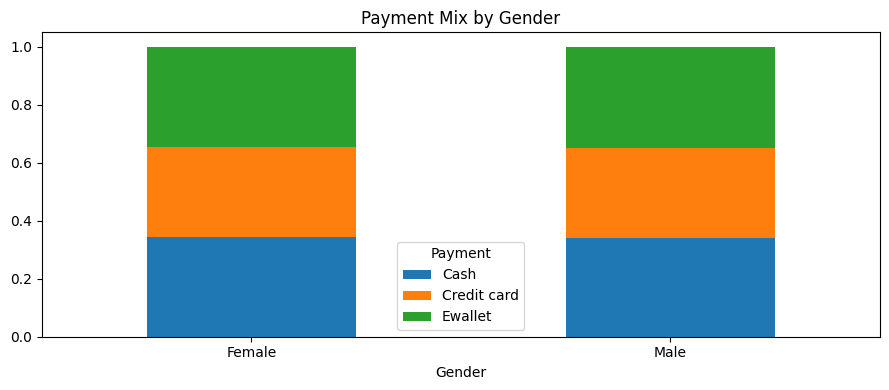

Payment,Cash,Credit card,Ewallet
Customer type,,,
Member,0.344282,0.308501,0.347217
Normal,0.340571,0.313264,0.346165


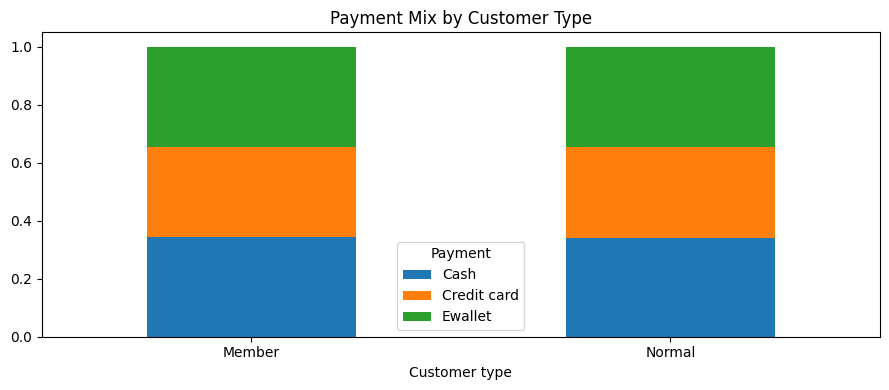

In [10]:
pay_gender = df.pivot_table(index='Gender', columns='Payment', values=COL_SALES, aggfunc='count').fillna(0)
pay_gender = pay_gender.div(pay_gender.sum(axis=1), axis=0)
display(pay_gender)
pay_gender.plot(kind='bar', stacked=True, figsize=(9,4), rot=0, title='Payment Mix by Gender')
plt.tight_layout(); plt.show()

pay_cust = df.pivot_table(index='Customer type', columns='Payment', values=COL_SALES, aggfunc='count').fillna(0)
pay_cust = pay_cust.div(pay_cust.sum(axis=1), axis=0)
display(pay_cust)
pay_cust.plot(kind='bar', stacked=True, figsize=(9,4), rot=0, title='Payment Mix by Customer Type')
plt.tight_layout(); plt.show()

#### D5) Time-of-Day Opportunity

,Time_of_day,transactions,total_sales,avg_sales,total_gi,avg_gi,avg_rating,pct_high_value
0,Afternoon,45552,779292.819566,17.107763,135764.348506,2.980426,6.973767,0.201089
1,Evening,35272,601379.203705,17.049762,105098.942449,2.979671,6.985112,0.200953
2,Morning,19176,327213.688853,17.063709,57113.759926,2.978398,6.969082,0.195661


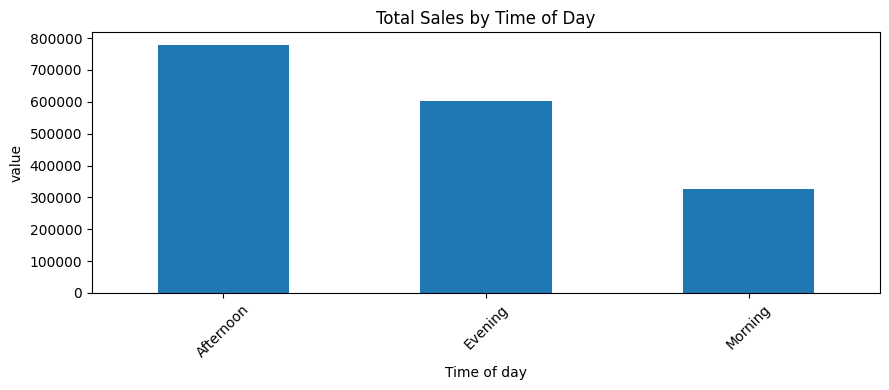

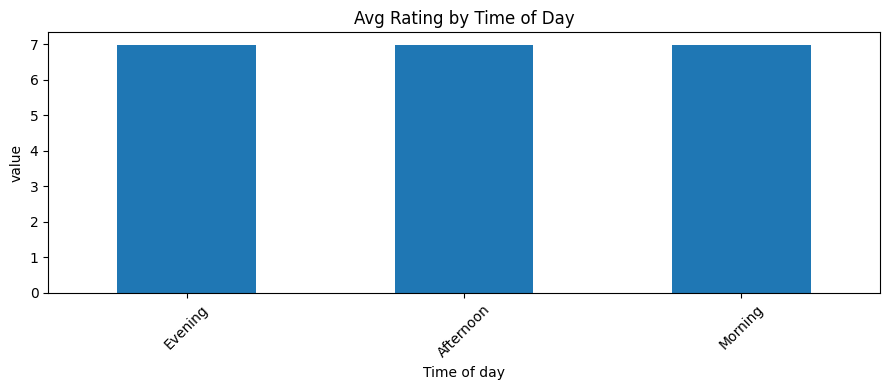

In [11]:
d5 = seg_metrics(df.groupby(['Time_of_day']))
display(d5)
bar_from_series(d5.set_index('Time_of_day')['total_sales'], 'Total Sales by Time of Day', 'Time of day')
bar_from_series(d5.set_index('Time_of_day')['avg_rating'], 'Avg Rating by Time of Day', 'Time of day')

#### D6) Day-of-Week Cadence

,Day_of_week,transactions,total_sales,avg_sales,total_gi,avg_gi,avg_rating,pct_high_value
1,Monday,14231,234675.106042,16.490416,42042.891155,2.954317,6.965218,0.198018
5,Tuesday,14369,251383.799546,17.494871,43266.122776,3.011074,6.966070,0.207182
6,Wednesday,14190,240040.292735,16.916159,42111.272048,2.967672,6.982244,0.199930
4,Thursday,14401,243781.153969,16.928071,42684.221302,2.963976,7.000013,0.197764
0,Friday,14110,239586.085428,16.979878,42003.866512,2.976886,7.000592,0.195606
2,Saturday,14357,255826.987124,17.818972,43353.016314,3.019643,6.978277,0.202549
3,Sunday,14342,242592.287282,16.914816,42515.660775,2.964416,6.945952,0.198857


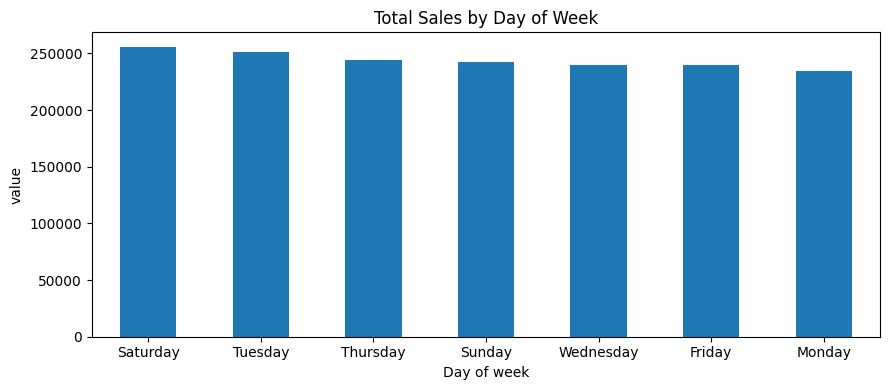

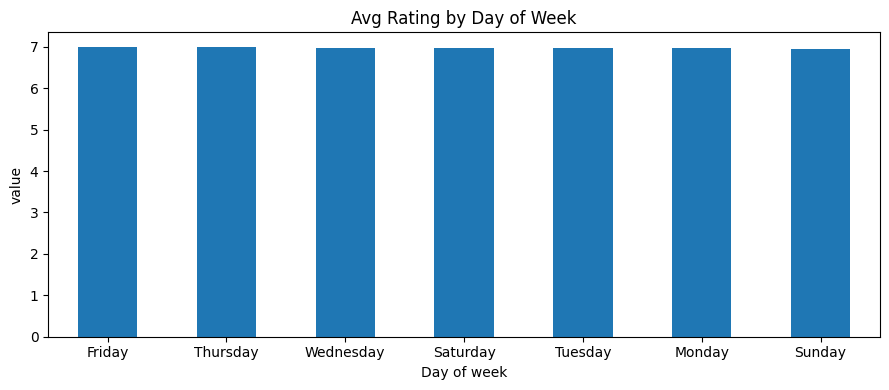

In [12]:
d6 = seg_metrics(df.groupby(['Day_of_week']))
order = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
d6['Day_of_week'] = pd.Categorical(d6['Day_of_week'], categories=order, ordered=True)
d6 = d6.sort_values('Day_of_week')
display(d6)
bar_from_series(d6.set_index('Day_of_week')['total_sales'], 'Total Sales by Day of Week', 'Day of week', rot=0)
bar_from_series(d6.set_index('Day_of_week')['avg_rating'], 'Avg Rating by Day of Week', 'Day of week', rot=0)

#### D7) Product line × Gender Performance
**Gemini Prompt:**
> From the imported pandas DataFrame `df`, compute a decision matrix for **Product line × Gender**.
> Show *Avg Sales/Txn*, *Avg Gross Income/Txn*, *Avg Units/Txn*, and *Avg Rating*; visualize as heatmaps/bar charts.
> Highlight categories where one gender materially outperforms the other.

,Product line,Gender,avg_sales,avg_gi,avg_qty,avg_rating,txns
0,Electronic accessories,Female,17.089705,3.000249,1.955059,6.949542,9657
1,Electronic accessories,Male,17.043555,2.977694,1.953078,6.973391,7374
2,Fashion accessories,Female,17.174075,2.979484,1.950202,6.958225,10141
3,Fashion accessories,Male,16.511718,2.937503,1.9366,6.983580,7571
4,Food and beverages,Female,17.422502,2.987362,1.94609,6.998767,9924
5,Food and beverages,Male,16.489187,2.948760,1.950765,6.945803,7515
6,Health and beauty,Female,16.445595,2.928188,1.948535,6.972706,8666
7,Health and beauty,Male,17.865645,3.044415,1.958435,6.980895,6544
8,Home and lifestyle,Female,17.505037,2.992642,1.957946,6.958027,9155
9,Home and lifestyle,Male,16.911822,2.993089,1.952982,7.014597,6891


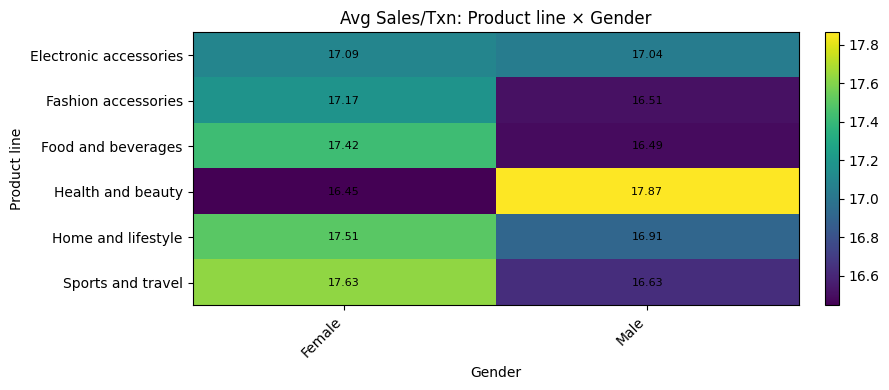

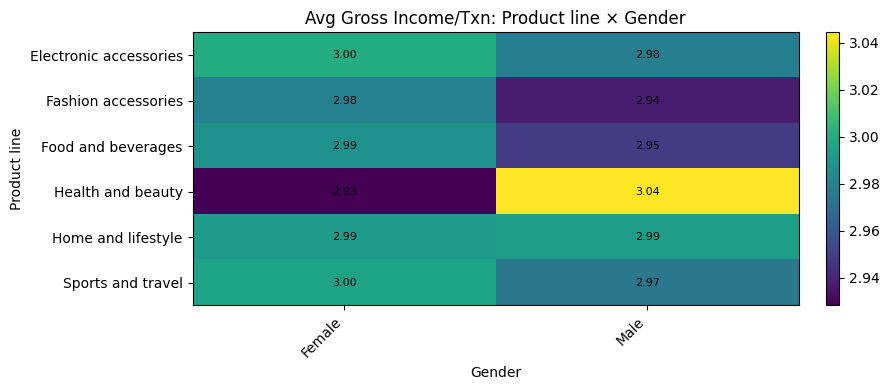

In [13]:
# D7) Product line × Gender performance matrix
pl_g = (df.groupby(['Product line','Gender'])
          .agg(avg_sales=('Sales','mean'),
               avg_gi=('gross income','mean'),
               avg_qty=('Quantity','mean'),
               avg_rating=('Rating','mean'),
               txns=('Sales','size'))
          .reset_index())
display(pl_g)
piv_sales = pl_g.pivot_table(index='Product line', columns='Gender', values='avg_sales', fill_value=0)
piv_gi    = pl_g.pivot_table(index='Product line', columns='Gender', values='avg_gi', fill_value=0)
heatmap_from_pivot(piv_sales, 'Avg Sales/Txn: Product line × Gender', 'Gender', 'Product line')
heatmap_from_pivot(piv_gi, 'Avg Gross Income/Txn: Product line × Gender', 'Gender', 'Product line')

#### D8) Customer type × Time of day
**Gemini Prompt:**
> Using `df`, build a **Customer type × Time_of_day** matrix with *Avg Sales*, *Avg Rating*, and *% High‑Value*.
> Plot heatmaps to reveal high‑opportunity windows for each customer type.

,Customer type,Time_of_day,avg_sales,avg_rating,pct_hv,txns
0,Member,Afternoon,17.221383,6.986417,0.203215,25628
1,Member,Evening,17.279962,6.968213,0.202938,20080
2,Member,Morning,17.117850,6.969984,0.196427,10859
3,Normal,Afternoon,16.961614,6.957495,0.198354,19924
4,Normal,Evening,16.745496,7.007450,0.198328,15192
5,Normal,Morning,16.993021,6.967904,0.194662,8317


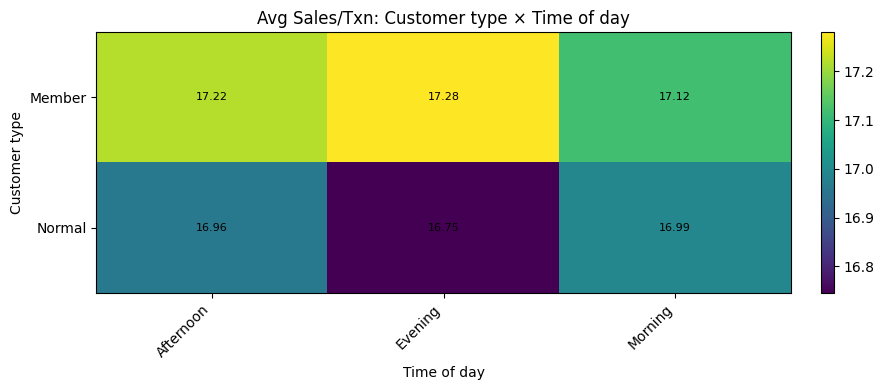

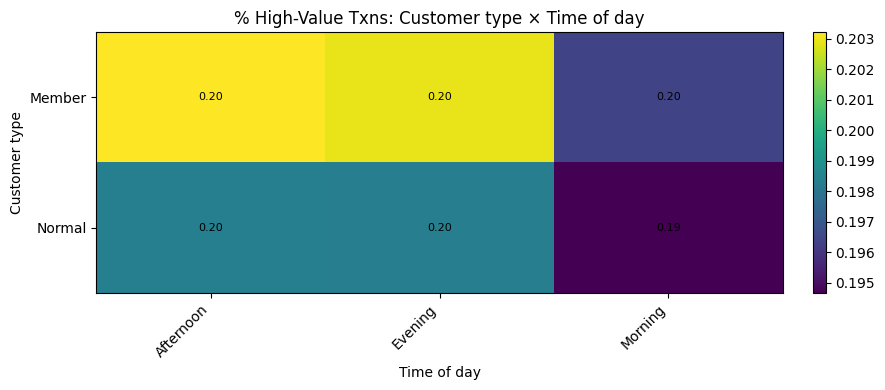

In [14]:
# D8) Customer type × Time_of_day decision matrix
d8 = (df.groupby(['Customer type','Time_of_day'])
        .agg(avg_sales=('Sales','mean'),
             avg_rating=('Rating','mean'),
             pct_hv=('High_value','mean'),
             txns=('Sales','size'))
        .reset_index())
display(d8)
p1 = d8.pivot_table(index='Customer type', columns='Time_of_day', values='avg_sales', fill_value=0)
p2 = d8.pivot_table(index='Customer type', columns='Time_of_day', values='pct_hv', fill_value=0)
heatmap_from_pivot(p1, 'Avg Sales/Txn: Customer type × Time of day', 'Time of day', 'Customer type')
heatmap_from_pivot(p2, '% High-Value Txns: Customer type × Time of day', 'Time of day', 'Customer type')

#### D9) Payment Performance Matrix
**Gemini Prompt:**
> Construct a **Payment × KPI** decision matrix. For each payment method, compute *Avg Sales/Txn*, *Avg Rating*, and *% High‑Value*.
> Plot bars to compare performance across payment types.

,Payment,avg_sales,avg_rating,pct_hv,txns
0,Cash,17.109411,6.974644,0.199521,34267
1,Credit card,17.106209,6.982925,0.200277,31057
2,Ewallet,17.024166,6.973648,0.200225,34676


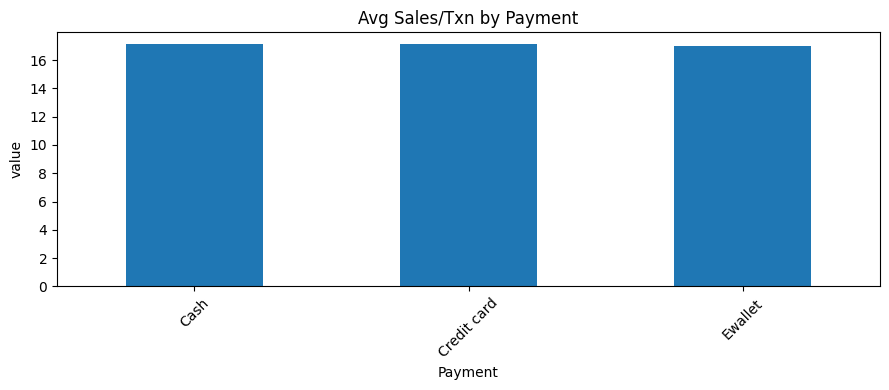

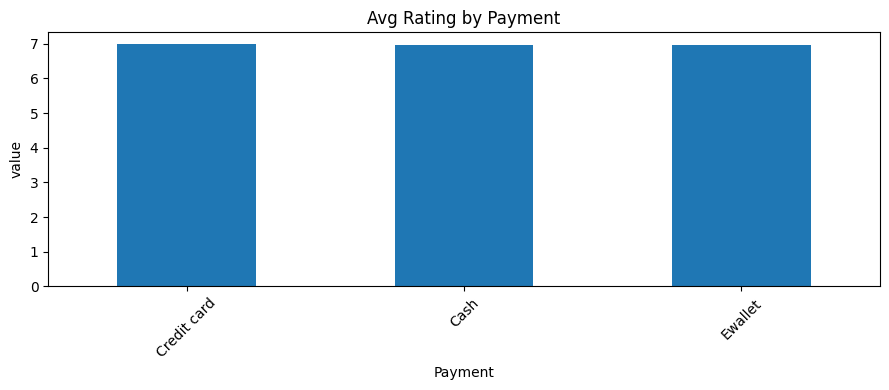

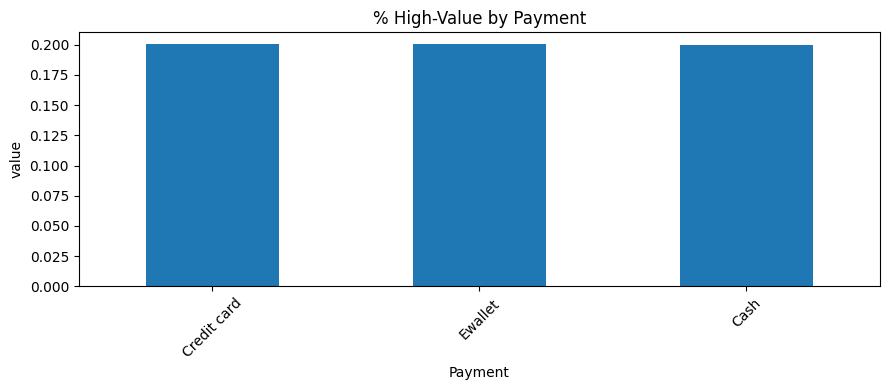

In [15]:
# D9) Payment Performance Matrix
pay_perf = (df.groupby('Payment')
              .agg(avg_sales=('Sales','mean'),
                   avg_rating=('Rating','mean'),
                   pct_hv=('High_value','mean'),
                   txns=('Sales','size'))
              .reset_index())
display(pay_perf)
bar_from_series(pay_perf.set_index('Payment')['avg_sales'], 'Avg Sales/Txn by Payment', 'Payment')
bar_from_series(pay_perf.set_index('Payment')['avg_rating'], 'Avg Rating by Payment', 'Payment')
bar_from_series(pay_perf.set_index('Payment')['pct_hv'], '% High-Value by Payment', 'Payment')

## Investigate Phase
### Gemini Prompt:
"Why do you think **[chosen pattern]** exists? What business factors could explain this? How can I validate these hypotheses?"

Provide the code to generate the below:

* **I1 – High-Value Drivers (Segment × Product line × Time\_of\_day)**

  * Matrix: pct\_high\_value (Customer type × Gender × Time\_of\_day) per Product line; plus top-N combos table
  * Plots: heatmap(% High-Value) for each Product line

* **I2 – Price–Quantity Sensitivity (per Product line)**

  * Matrix: corr(Unit price, Quantity) by Product line
  * Plots: bar(Correlation UP–Qty)

* **I3 – Experience Driver Matrix (Product line × Time\_of\_day)**

  * Matrices: avg\_rating; sales\_share; z-gap = z(rating) – z(sales\_share)
  * Plots: heatmap(Avg Rating), heatmap(Sales Share), heatmap(Rating – Sales z-gap)

* **I4 – Digital Readiness Proxy**

  * Matrix: ewallet\_share by (Customer type × Gender)
  * Plots: bar(E-wallet Share by Segment)

* **I5 – City × Product line Preference**

  * Matrix: row-wise category mix share by City
  * Plots: heatmap(Category Mix Share by City)

* **I6 – % High-Value by Customer type × Payment**

  * Matrix: %HV by (Customer type × Payment)
  * Plots: heatmap(% High-Value: Customer type × Payment)

* **I7 – Unit price ↔ Rating Sensitivity**

  * Matrix: corr(Unit price, Rating) by Product line
  * Plots: bar(Correlation UP–Rating)

* **I8 – Hour × Category High-Value Propensity**

  * Matrix: %HV by (Hour 0–23 × Product line)
  * Plots: heatmap(% High-Value by Hour × Product line)

* **I9 – Payment × Category High-Value**

  * Matrix: %HV by (Payment × Product line)
  * Plots: heatmap(% High-Value: Payment × Product line)


#### I1) High-Value Drivers — Segment × Product line × Time_of_day

,Customer type,Gender,Product line,Time_of_day,pct_high_value
28,Member,Male,Health and beauty,Evening,0.220930
30,Member,Male,Home and lifestyle,Afternoon,0.220749
24,Member,Male,Food and beverages,Afternoon,0.218271
53,Normal,Female,Sports and travel,Morning,0.217165
61,Normal,Male,Food and beverages,Evening,0.215993
54,Normal,Male,Electronic accessories,Afternoon,0.212557
51,Normal,Female,Sports and travel,Afternoon,0.211187
1,Member,Female,Electronic accessories,Evening,0.210792
13,Member,Female,Home and lifestyle,Evening,0.209433
49,Normal,Female,Home and lifestyle,Evening,0.209336


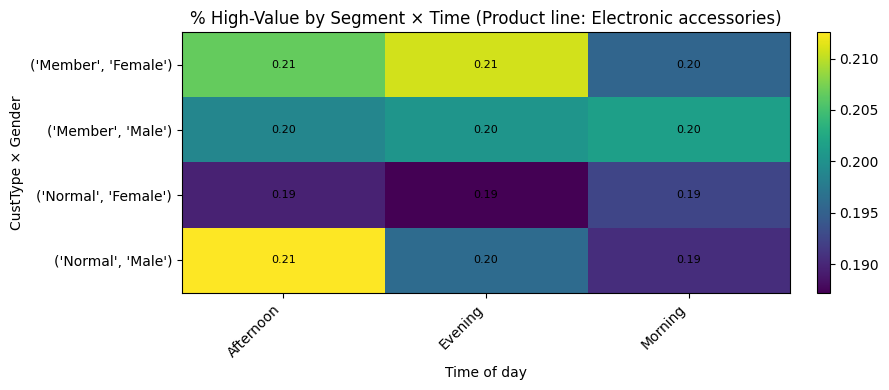

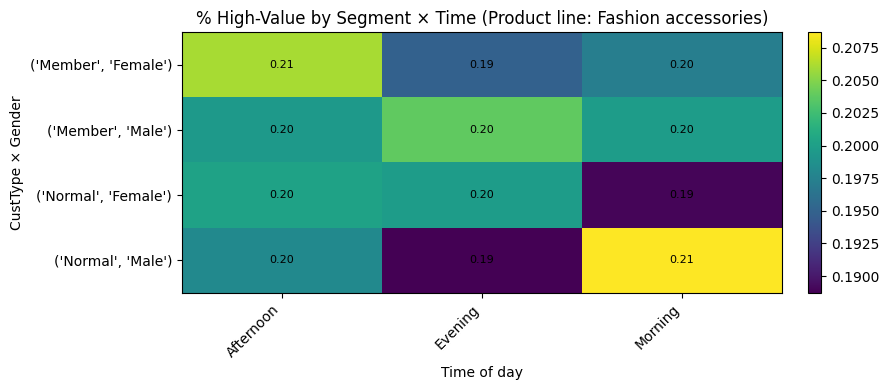

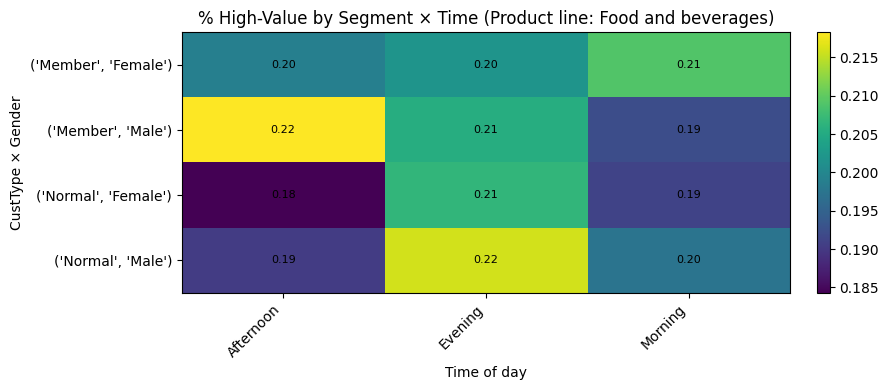

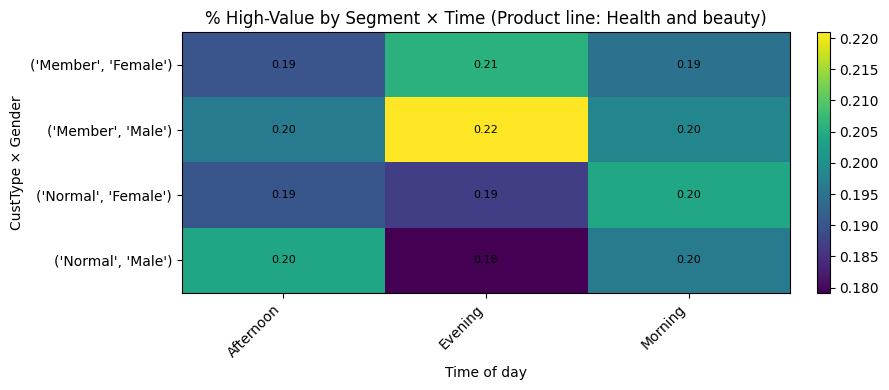

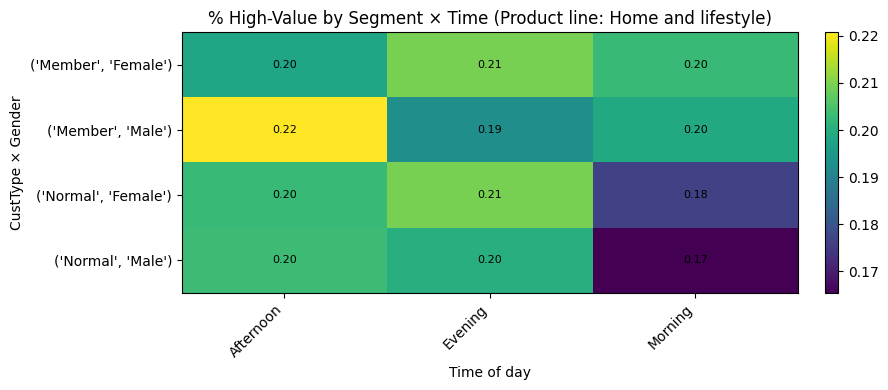

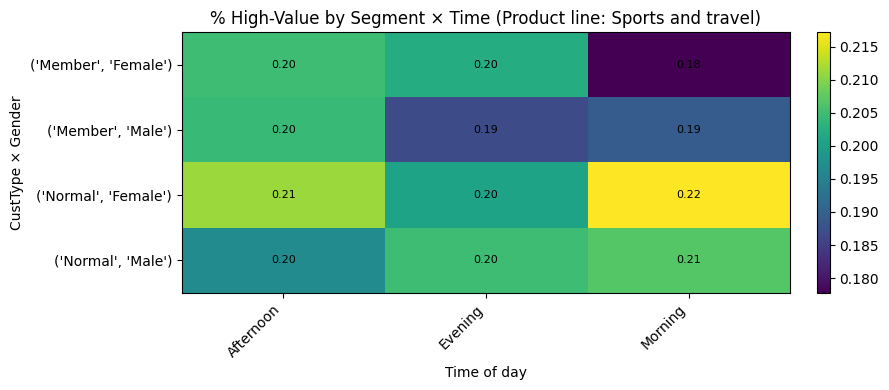

In [16]:
i1 = (df.groupby(['Customer type','Gender','Product line','Time_of_day'])['High_value']
        .mean().rename('pct_high_value').reset_index())
display(i1.sort_values('pct_high_value', ascending=False).head(25))
for pl, sub in i1.groupby('Product line'):
    piv = sub.pivot_table(index=['Customer type','Gender'], columns='Time_of_day', values='pct_high_value', fill_value=0)
    heatmap_from_pivot(piv, f'% High-Value by Segment × Time (Product line: {pl})', 'Time of day', 'CustType × Gender')

#### I2) Price–Quantity Sensitivity — Correlation within Product line

/tmp/ipython-input-1509446790.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  corrs = df.groupby('Product line').apply(lambda g: g['Unit price'].corr(g['Quantity']))\


,Product line,corr_up_qty
0,Electronic accessories,0.484560
1,Fashion accessories,0.452702
2,Food and beverages,0.491067
3,Health and beauty,0.498643
4,Home and lifestyle,0.523288
5,Sports and travel,0.496672


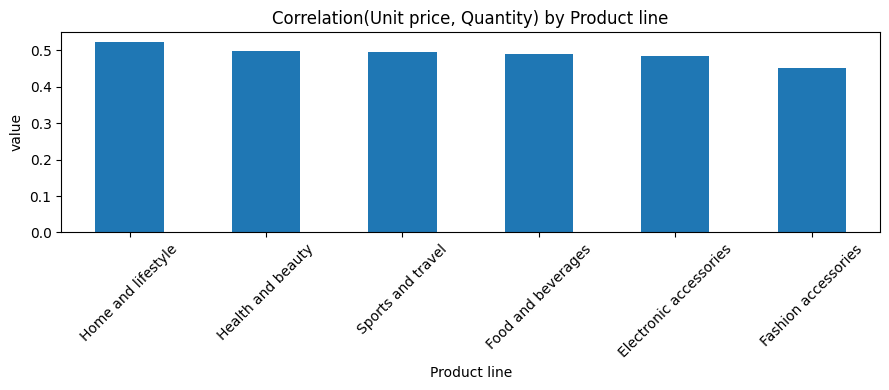

In [17]:
corrs = df.groupby('Product line').apply(lambda g: g['Unit price'].corr(g['Quantity']))\
         .rename('corr_up_qty').reset_index()
display(corrs)
bar_from_series(corrs.set_index('Product line')['corr_up_qty'], 'Correlation(Unit price, Quantity) by Product line', 'Product line')

#### I3) Experience Drivers — Rating vs Sales Share by Product line × Time_of_day

Time_of_day,Afternoon,Evening,Morning
Product line,,,
Electronic accessories,6.978342,6.942254,6.948763
Fashion accessories,6.961141,6.983334,6.961533
Food and beverages,6.983507,6.990283,6.931226
Health and beauty,6.962547,6.982368,6.998468
Home and lifestyle,6.984131,6.976580,6.988429
Sports and travel,6.972703,7.035861,6.993350


Time_of_day,Afternoon,Evening,Morning
Product line,,,
Electronic accessories,0.166424,0.174467,0.171449
Fashion accessories,0.176614,0.172003,0.177558
Food and beverages,0.169598,0.178174,0.175727
Health and beauty,0.154827,0.150387,0.147716
Home and lifestyle,0.162121,0.160076,0.165617
Sports and travel,0.170415,0.164893,0.161933


Time_of_day,Afternoon,Evening,Morning
Product line,,,
Electronic accessories,0.109689,-2.298331,-1.692644
Fashion accessories,-1.733071,-0.288805,-1.819696
Food and beverages,-0.018574,-0.669252,-2.903161
Health and beauty,0.708573,2.033635,3.007642
Home and lifestyle,0.825357,0.729155,0.625195
Sports and travel,-0.565576,2.713482,1.236382


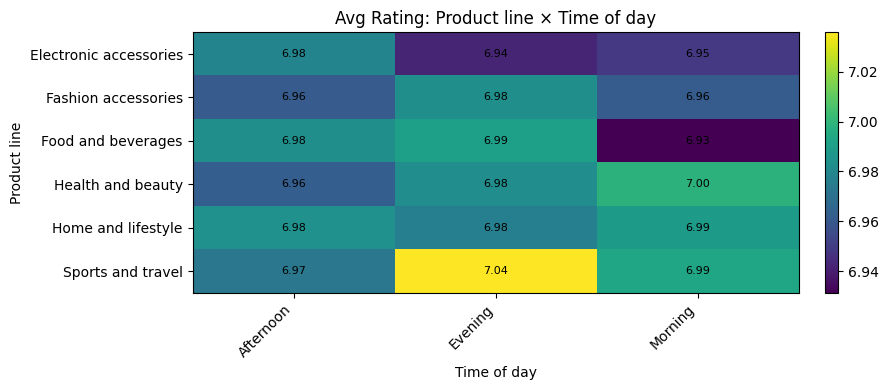

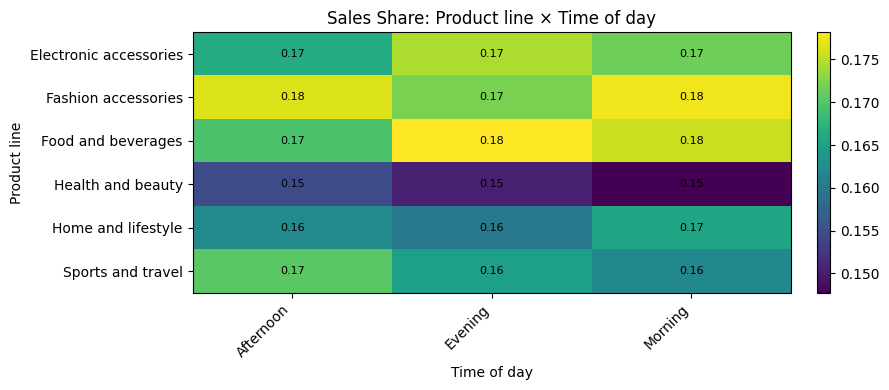

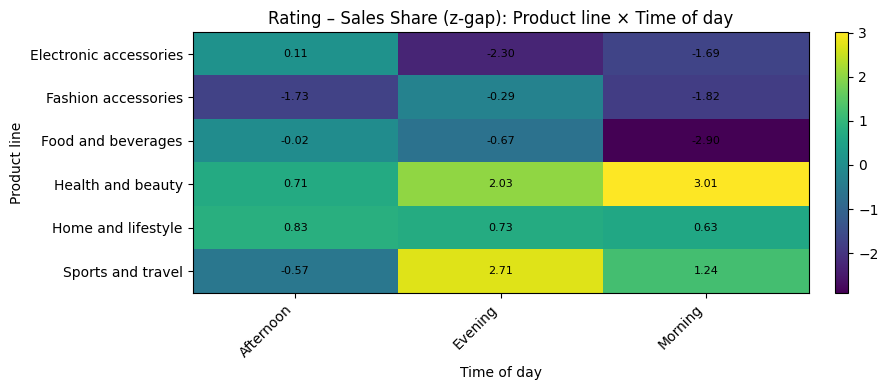

In [18]:
rtg = df.pivot_table(index='Product line', columns='Time_of_day', values=COL_RTG, aggfunc='mean').fillna(0)
sales = df.pivot_table(index='Product line', columns='Time_of_day', values=COL_SALES, aggfunc='sum').fillna(0)
sales_share = sales.div(sales.sum().replace(0,np.nan), axis=1).fillna(0)

def z(df_):
    s = df_.stack()
    return (df_ - s.mean()) / s.std()

gap = z(rtg) - z(sales_share)
display(rtg)
display(sales_share)
display(gap)
heatmap_from_pivot(rtg, 'Avg Rating: Product line × Time of day', 'Time of day', 'Product line')
heatmap_from_pivot(sales_share, 'Sales Share: Product line × Time of day', 'Time of day', 'Product line')
heatmap_from_pivot(gap, 'Rating – Sales Share (z-gap): Product line × Time of day', 'Time of day', 'Product line')

#### I4) Digital Readiness Proxy — E‑wallet share by Segment

Customer type  Gender
Member         Female    0.345491
               Male      0.349527
Normal         Female    0.344126
               Male      0.348848
Name: is_ewallet, dtype: float64

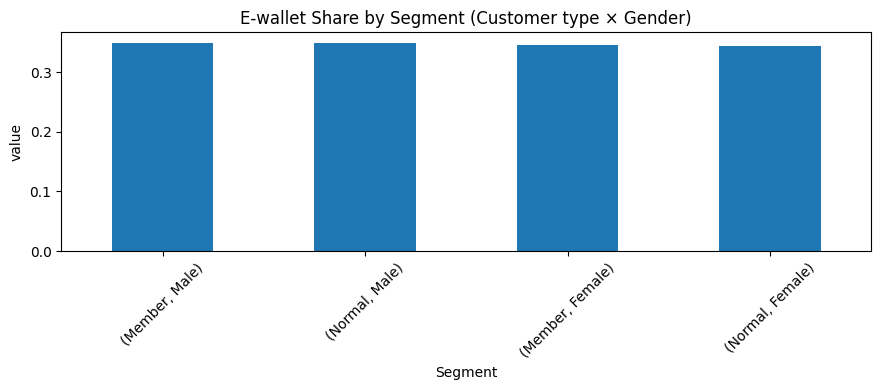

In [19]:
tmp = (df.assign(is_ewallet = (df['Payment']=='Ewallet').astype(int))
         .groupby(['Customer type','Gender'])['is_ewallet']
         .mean())
display(tmp)
bar_from_series(tmp, 'E-wallet Share by Segment (Customer type × Gender)', 'Segment')

#### I5) City × Product line Preference — Row-wise share

Product line,Electronic accessories,Fashion accessories,Food and beverages,Health and beauty,Home and lifestyle,Sports and travel
City,,,,,,
Mandalay,0.170874,0.171777,0.169848,0.158662,0.158625,0.170215
Naypyitaw,0.171311,0.180471,0.179982,0.151669,0.155951,0.160615
Yangon,0.168496,0.173246,0.171524,0.145512,0.171505,0.169718


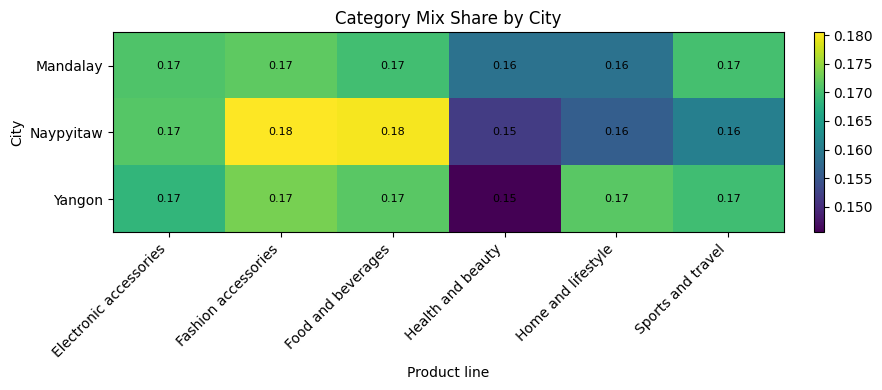

In [20]:
i5 = (df.pivot_table(index='City', columns='Product line', values=COL_SALES, aggfunc='sum')
        .apply(lambda r: r/r.sum() if r.sum() else r, axis=1).fillna(0))
display(i5)
heatmap_from_pivot(i5, 'Category Mix Share by City', 'Product line', 'City')

#### I6) % High‑Value by Customer type × Payment
**Gemini Prompt:**
> Build a **Customer type × Payment** matrix of **% High‑Value transactions**.
> Where does payment choice most strongly correlate with high-value behavior? Visualize as a heatmap.

,Customer type,Payment,%HV
0,Member,Cash,0.202619
1,Member,Credit card,0.204630
2,Member,Ewallet,0.198513
3,Normal,Cash,0.195443
4,Normal,Credit card,0.194694
5,Normal,Ewallet,0.202461


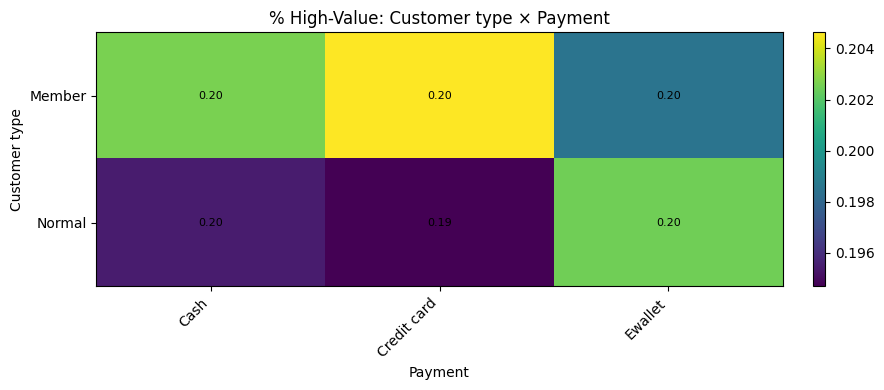

In [21]:
# I6) % High-Value by Customer type × Payment
i6 = (df.groupby(['Customer type','Payment'])['High_value'].mean().rename('%HV').reset_index())
display(i6)
p = i6.pivot_table(index='Customer type', columns='Payment', values='%HV', fill_value=0)
heatmap_from_pivot(p, '% High-Value: Customer type × Payment', 'Payment', 'Customer type')

#### I7) Unit price ↔ Rating Sensitivity
**Gemini Prompt:**
> For each product line, compute the correlation between **Unit price** and **Rating** as a proxy for perceived value sensitivity.
> Plot the correlations as bars; flag strong negative relationships.

/tmp/ipython-input-2656070214.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  i7 = df.groupby('Product line').apply(lambda g: g['Unit price'].corr(g['Rating']))\


,Product line,corr_up_rating
0,Electronic accessories,-0.004912
1,Fashion accessories,0.009664
2,Food and beverages,0.003598
3,Health and beauty,0.004958
4,Home and lifestyle,-0.007409
5,Sports and travel,0.003750


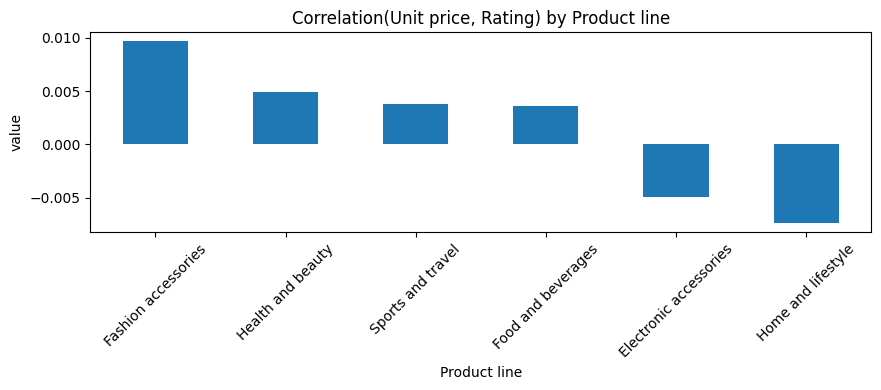

In [22]:
# I7) Correlation(Unit price, Rating) by Product line
i7 = df.groupby('Product line').apply(lambda g: g['Unit price'].corr(g['Rating']))\
       .rename('corr_up_rating').reset_index()
display(i7)
bar_from_series(i7.set_index('Product line')['corr_up_rating'], 'Correlation(Unit price, Rating) by Product line', 'Product line')

#### I8) Hour × Category High‑Value Propensity
**Gemini Prompt:**
> Create a **Hour-of-day × Product line** matrix showing **% High‑Value** to find precise time windows when categories skew premium.
> Visualize as a heatmap (hours 0–23).

,hour,Product line,pct_hv
0,10,Electronic accessories,0.195276
1,10,Fashion accessories,0.206822
2,10,Food and beverages,0.202560
3,10,Health and beauty,0.191503
4,10,Home and lifestyle,0.172693


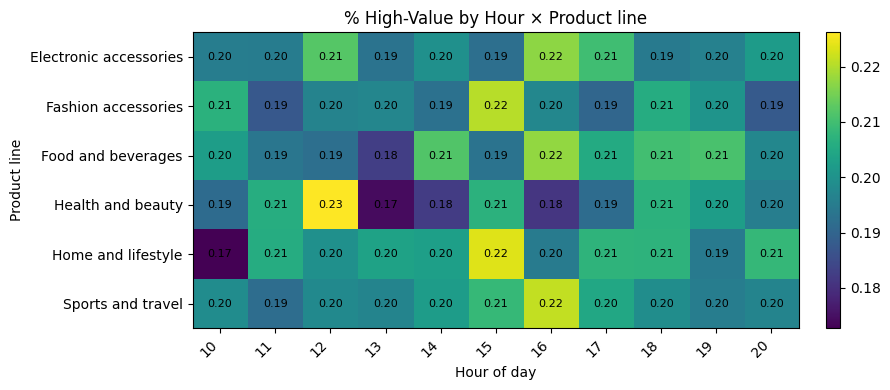

In [23]:
# I8) Hour-of-day × Product line: % High-Value
i8 = (df.groupby([df['Hour'], 'Product line'])['High_value'].mean().rename('pct_hv').reset_index())
i8 = i8.rename(columns={'Hour':'hour'})
display(i8.head())
p = i8.pivot_table(index='Product line', columns='hour', values='pct_hv', fill_value=0)
heatmap_from_pivot(p, '% High-Value by Hour × Product line', 'Hour of day', 'Product line')

#### I9) Payment × Category High‑Value
**Gemini Prompt:**
> Compute a **Payment × Product line** matrix of **% High‑Value**.
> Which payment methods are associated with premium baskets within each category?

,Payment,Product line,pct_hv
0,Cash,Electronic accessories,0.206420
1,Cash,Fashion accessories,0.192063
2,Cash,Food and beverages,0.197171
3,Cash,Health and beauty,0.200683
4,Cash,Home and lifestyle,0.196157


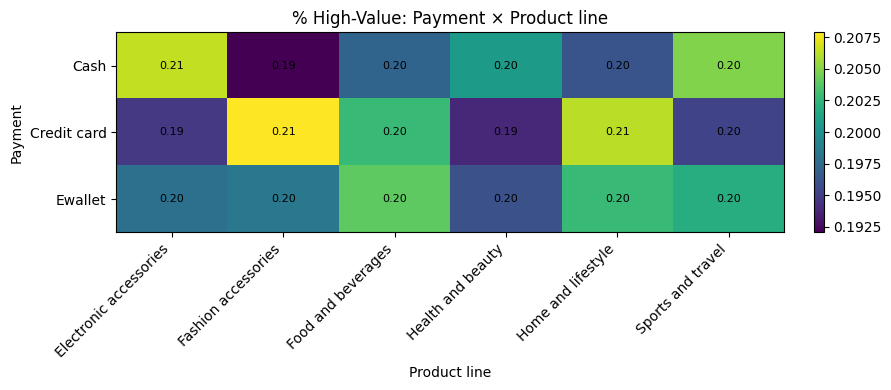

In [24]:
# I9) Payment × Product line: % High-Value
i9 = (df.groupby(['Payment','Product line'])['High_value'].mean().rename('pct_hv').reset_index())
display(i9.head())
p = i9.pivot_table(index='Payment', columns='Product line', values='pct_hv', fill_value=0)
heatmap_from_pivot(p, '% High-Value: Payment × Product line', 'Product line', 'Payment')

## Validate Phase
### Gemini Prompt:


Provide the code to generate the below:

* **V1 – Confounder Check (E-wallet share stability across Cities)**

  * Matrix: ewallet\_share by (Customer type × Gender × City)
  * Plots: bar(E-wallet Share across Cities) per segment

* **V2 – Threshold Sensitivity for High-Value (75/80/85/90th)**

  * Matrix: quantile, threshold, share\_txn, share\_revenue
  * Plots: bar(share\_txn & share\_revenue by quantile)

* **V3 – Alternate Segments (k-means)**

  * Matrix: avg\_sales, avg\_gi, avg\_rating, transactions, total\_sales by cluster
  * Plots: bar(Avg Sales/Txn by Cluster), bar(Avg GI/Txn by Cluster), bar(Avg Rating by Cluster)

* **V4 – Seasonality Proxy (Month)**

  * Matrix: avg\_sales, avg\_gi, avg\_rating, transactions, total\_sales by Month
  * Plots: bar(Total Sales by Month), bar(Avg Rating by Month)

* **V5 – Location Bias on High-Value (City × Product line)**

  * Matrix: %HV by City × Product line; variance table (mean, std\_across\_cities) per Product line
  * Plots: heatmap(% High-Value: City × Product line)

* **V6 – Bootstrap Confidence Intervals (Product line)**

  * Matrix: avg\_sales\_hat with \[ci\_lo\_sales, ci\_hi\_sales]; avg\_gi\_hat with \[ci\_lo\_gi, ci\_hi\_gi]
  * Plots: errorbar(Avg Sales/Txn 95% CI), errorbar(Avg GI/Txn 95% CI)

* **V7 – Random Holdout Stability (Half-split)**

  * Matrix: Half A vs Half B avg\_sales by Product line
  * Plots: bar(Half-Split Avg Sales/Txn by Product line)


#### V1) Confounder Check — E‑wallet share stability across Cities

,Customer type,Gender,City,is_ewallet
0,Member,Female,Mandalay,0.346337
1,Member,Female,Naypyitaw,0.342776
2,Member,Female,Yangon,0.347283
3,Member,Male,Mandalay,0.348323
4,Member,Male,Naypyitaw,0.351055
5,Member,Male,Yangon,0.349212
6,Normal,Female,Mandalay,0.343670
7,Normal,Female,Naypyitaw,0.346817
8,Normal,Female,Yangon,0.342003
9,Normal,Male,Mandalay,0.340019


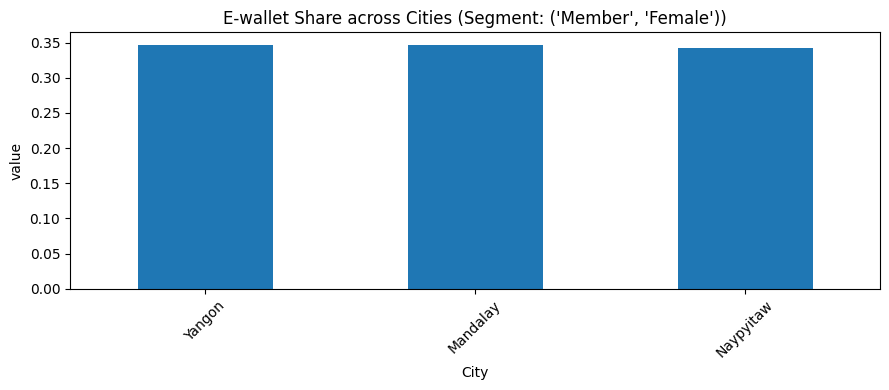

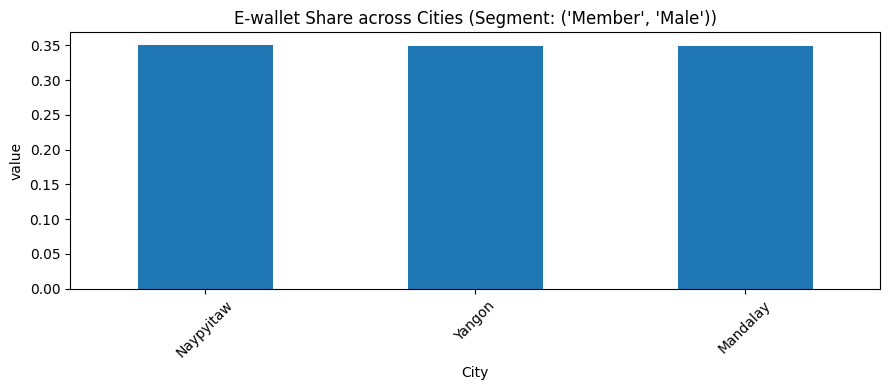

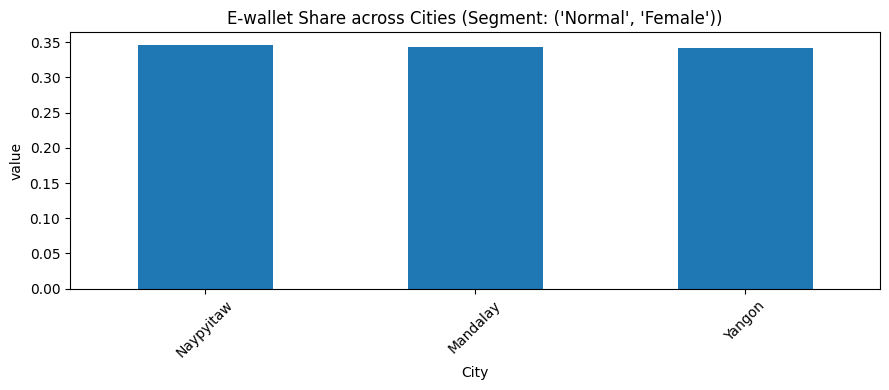

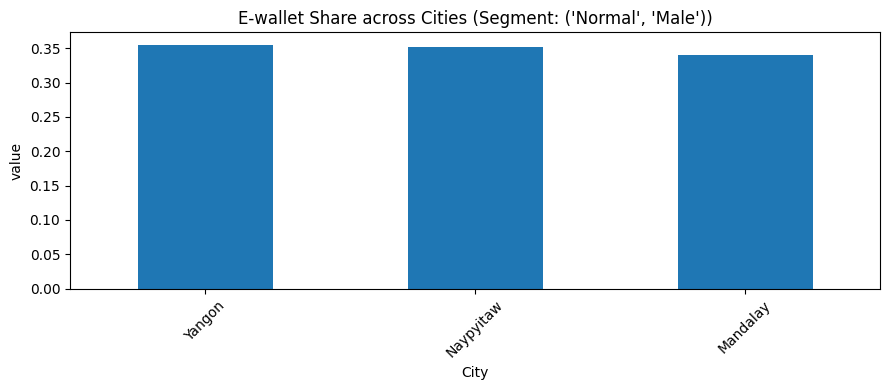

In [25]:
v1 = (df.assign(is_ewallet=(df['Payment']=='Ewallet').astype(int))
        .groupby(['Customer type','Gender','City'])['is_ewallet']
        .mean().reset_index())
display(v1.head(12))
for seg, sub in v1.groupby(['Customer type','Gender']):
    s = sub.set_index('City')['is_ewallet']
    bar_from_series(s, f'E-wallet Share across Cities (Segment: {seg})', 'City')

#### V2) Threshold Sensitivity — High-value cutoffs (75/80/85/90th)

,quantile,threshold,share_txn,share_revenue
0,0.75,18.996475,0.25,0.532039
1,0.80,20.493634,0.20,0.474291
2,0.85,22.323777,0.15,0.411720
3,0.90,24.755750,0.10,0.342966


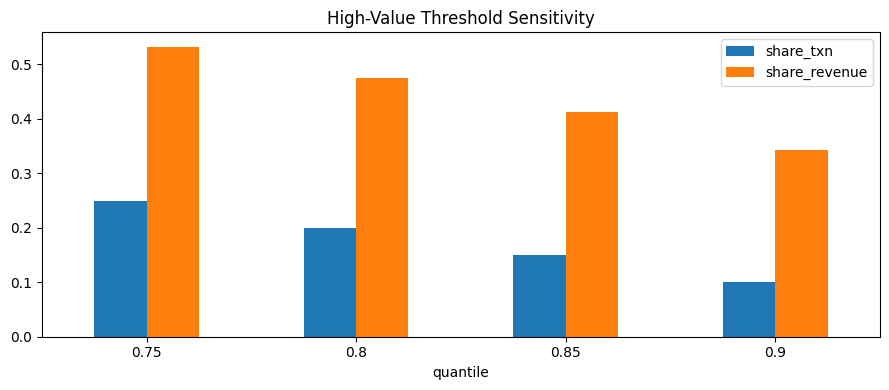

In [26]:
cuts = [0.75,0.80,0.85,0.90]
rows = []
for q in cuts:
    thr = df[COL_SALES].quantile(q)
    hv  = df[COL_SALES] >= thr
    rows.append({'quantile': q,
                 'threshold': thr,
                 'share_txn': hv.mean(),
                 'share_revenue': df.loc[hv, COL_SALES].sum()/df[COL_SALES].sum()})
v2 = pd.DataFrame(rows)
display(v2)
v2.set_index('quantile')[['share_txn','share_revenue']].plot(kind='bar', figsize=(9,4), rot=0, title='High-Value Threshold Sensitivity')
plt.tight_layout(); plt.show()

#### V3) Alternate Segments — Compact k-means on numeric features (optional)

,cluster,transactions,total_sales,avg_sales,total_gi,avg_gi,avg_rating,pct_high_value
0,0,50073,723386.401088,14.446636,144808.522353,2.891948,5.619021,0.198151
1,1,613,282873.223500,461.457135,13470.153500,21.974149,6.943719,1.000000
2,2,49314,701626.087535,14.227726,139698.375029,2.832834,8.356030,0.191933


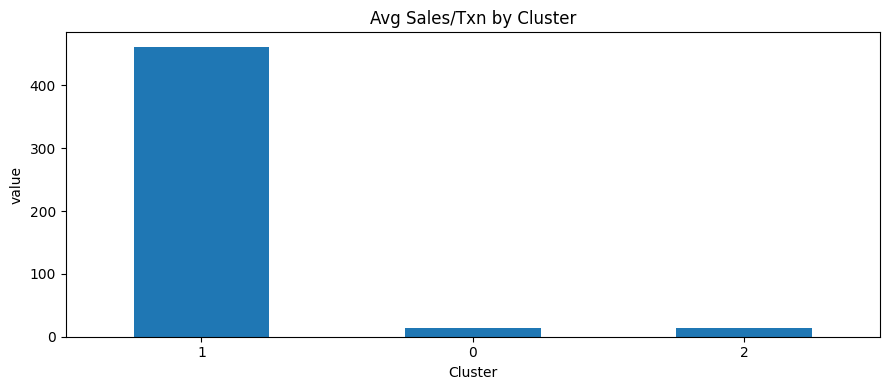

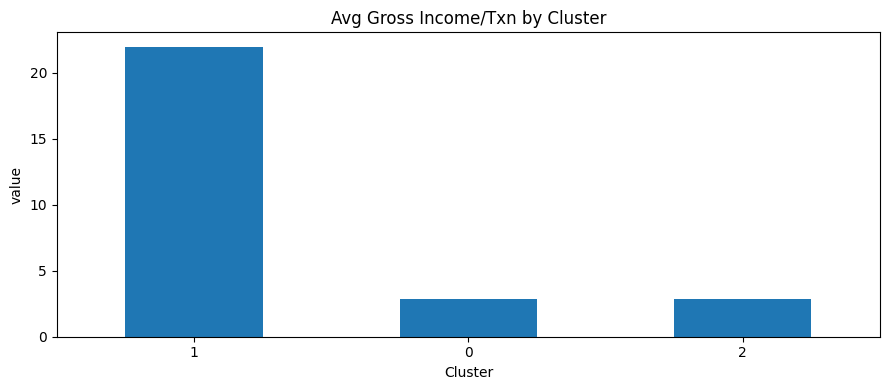

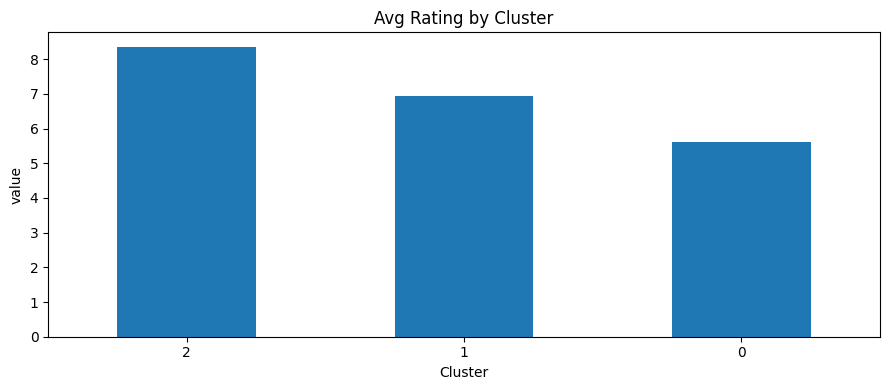

In [27]:
!pip -q install scikit-learn
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

X = df[['Unit price','Quantity',COL_SALES,COL_GI,COL_RTG]].copy()
X = X.fillna(X.median())
Xs = StandardScaler().fit_transform(X)

km = KMeans(n_clusters=3, n_init='auto', random_state=42).fit(Xs)
df['cluster'] = km.labels_

v3 = seg_metrics(df.groupby('cluster'))
display(v3)
bar_from_series(v3.set_index('cluster')['avg_sales'], 'Avg Sales/Txn by Cluster', 'Cluster', rot=0)
bar_from_series(v3.set_index('cluster')['avg_gi'], 'Avg Gross Income/Txn by Cluster', 'Cluster', rot=0)
bar_from_series(v3.set_index('cluster')['avg_rating'], 'Avg Rating by Cluster', 'Cluster', rot=0)

#### V4) Seasonality Proxy — Month-level stability

,Month,transactions,total_sales,avg_sales,total_gi,avg_gi,avg_rating,pct_high_value
4,January,5013,183678.888759,36.640512,19263.519868,3.842713,6.984297,0.259126
3,February,4798,159903.994417,33.327219,17482.396936,3.643684,6.977653,0.233639
7,March,5133,174501.188387,33.995946,18487.230641,3.601642,7.010399,0.218975
0,April,9454,149318.471770,15.794211,30478.378786,3.223861,6.980327,0.272900
8,May,9540,145982.150724,15.302112,29746.919165,3.118126,6.978177,0.250943
6,June,9313,138509.725776,14.872729,28343.404082,3.043424,6.950353,0.224847
5,July,9503,137835.756307,14.504447,28171.966347,2.964534,7.003952,0.213827
1,August,9563,132961.440449,13.903737,27163.933145,2.840524,6.956636,0.189689
11,September,9280,125387.368264,13.511570,25495.105828,2.747317,6.977999,0.172414
10,October,9631,126943.756570,13.180745,25990.684350,2.698649,6.989880,0.155539


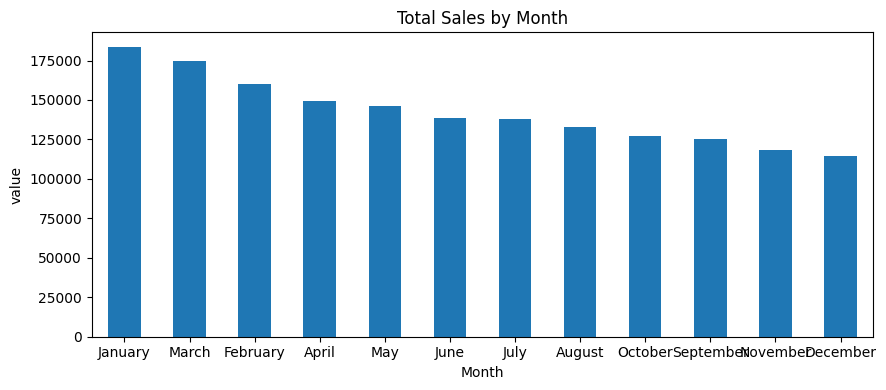

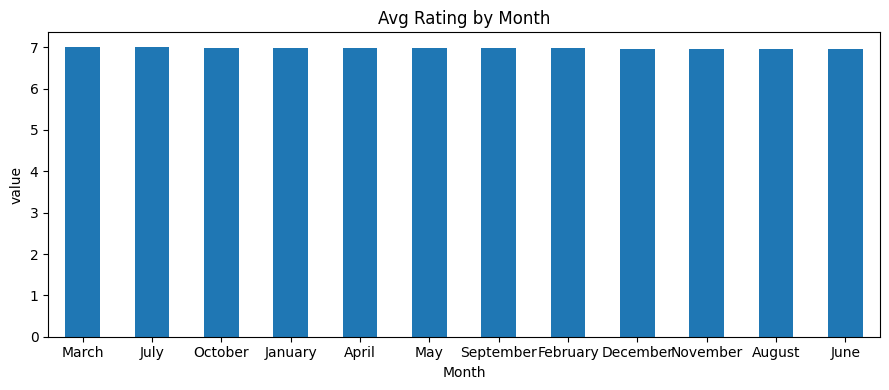

In [28]:
v4 = seg_metrics(df.groupby('Month'))
order = ['January','February','March','April','May','June','July','August','September','October','November','December']
v4['Month'] = pd.Categorical(v4['Month'], categories=order, ordered=True)
v4 = v4.sort_values('Month')
display(v4)
bar_from_series(v4.set_index('Month')['total_sales'], 'Total Sales by Month', 'Month', rot=0)
bar_from_series(v4.set_index('Month')['avg_rating'], 'Avg Rating by Month', 'Month', rot=0)

#### V5) Location Bias on High‑Value — City × Product line
**Gemini Prompt:**
> Test for **location bias** by building a **City × Product line** matrix of **% High‑Value**.
> Also compute per‑category variance across cities to assess stability of findings.

,City,Product line,pct_hv
0,Mandalay,Electronic accessories,0.192721
1,Mandalay,Fashion accessories,0.197253
2,Mandalay,Food and beverages,0.199556
3,Mandalay,Health and beauty,0.198959
4,Mandalay,Home and lifestyle,0.195164


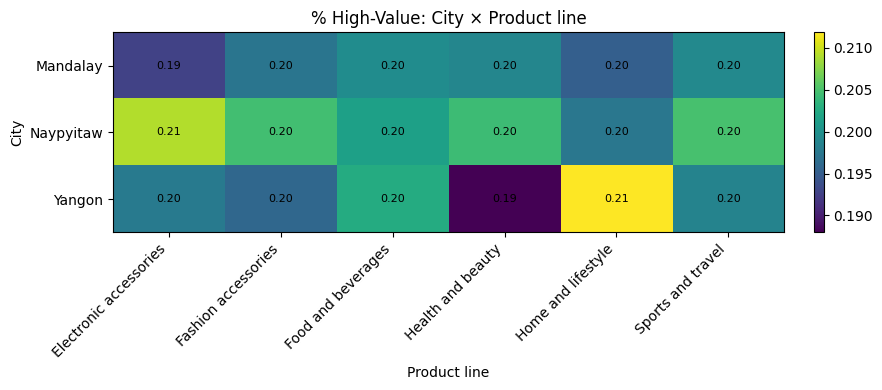

,Product line,mean,std_across_cities
4,Home and lifestyle,0.201483,0.009054
0,Electronic accessories,0.199885,0.008399
3,Health and beauty,0.197093,0.008349
1,Fashion accessories,0.199289,0.004706
5,Sports and travel,0.200928,0.003444
2,Food and beverages,0.201271,0.001592


In [29]:
# V5) % High-Value by City × Product line and variance
v5 = (df.groupby(['City','Product line'])['High_value'].mean().rename('pct_hv').reset_index())
display(v5.head())
p = v5.pivot_table(index='City', columns='Product line', values='pct_hv', fill_value=0)
heatmap_from_pivot(p, '% High-Value: City × Product line', 'Product line', 'City')
var_tbl = v5.groupby('Product line')['pct_hv'].agg(['mean','std']).rename(columns={'std':'std_across_cities'}).reset_index()
display(var_tbl.sort_values('std_across_cities', ascending=False))

#### V6) Bootstrap Confidence Intervals — Avg Sales & Avg GI per Product line
**Gemini Prompt:**
> Using non‑parametric bootstrap (1,000 resamples), estimate **95% CIs** for **Avg Sales/Txn** and **Avg GI/Txn** per **Product line**.
> Plot error bars to show uncertainty and identify unstable categories.

,Product line,avg_sales_hat,ci_lo_sales,ci_hi_sales,avg_gi_hat,ci_lo_gi,ci_hi_gi
0,Electronic accessories,17.069723,16.465051,17.713931,2.990483,2.953150,3.031160
1,Fashion accessories,16.890950,16.284956,17.486797,2.961539,2.925264,2.998873
2,Food and beverages,17.020308,16.451307,17.601913,2.970727,2.933802,3.007232
3,Health and beauty,17.056562,16.458089,17.696422,2.978193,2.938146,3.017709
4,Home and lifestyle,17.250279,16.604645,17.898494,2.992834,2.953573,3.032016
5,Sports and travel,17.205248,16.582210,17.821629,2.986565,2.949183,3.021607


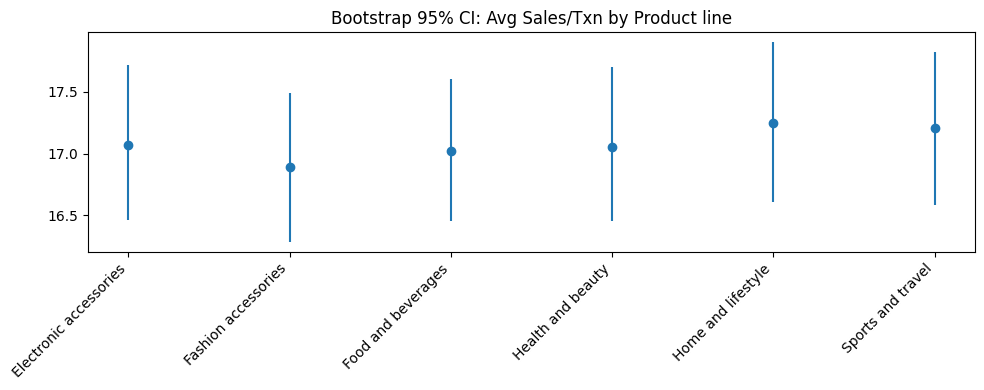

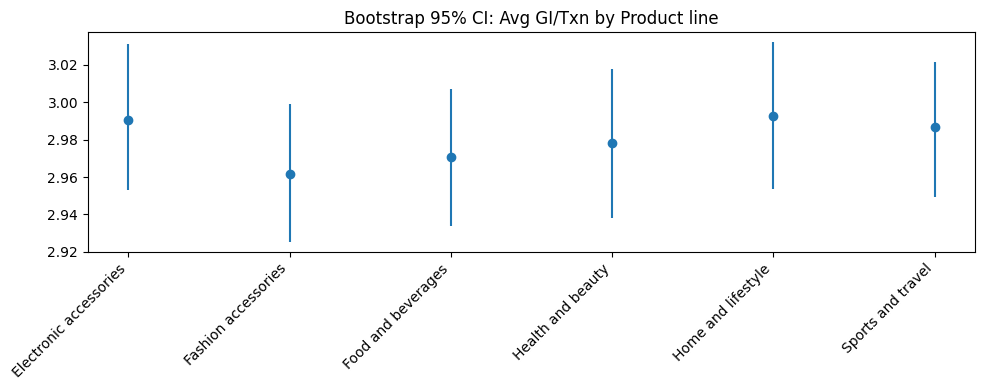

In [30]:
# V6) Bootstrap CIs for Avg Sales and Avg GI by Product line
rng = np.random.default_rng(42)
n_boot = 1000
lines = sorted(df['Product line'].dropna().unique())
rows = []
for pl in lines:
    x_sales = df.loc[df['Product line']==pl, 'Sales'].dropna().values
    x_gi    = df.loc[df['Product line']==pl, 'gross income'].dropna().values
    if len(x_sales) < 2:
        continue
    bs_sales = [rng.choice(x_sales, size=len(x_sales), replace=True).mean() for _ in range(n_boot)]
    bs_gi    = [rng.choice(x_gi,    size=len(x_gi),    replace=True).mean() for _ in range(n_boot)]
    lo_s, hi_s = np.percentile(bs_sales, [2.5,97.5])
    lo_g, hi_g = np.percentile(bs_gi,    [2.5,97.5])
    rows.append({'Product line':pl,
                 'avg_sales_hat': x_sales.mean(), 'ci_lo_sales': lo_s, 'ci_hi_sales': hi_s,
                 'avg_gi_hat':    x_gi.mean(),    'ci_lo_gi':    lo_g, 'ci_hi_gi':    hi_g})
v6 = pd.DataFrame(rows)
display(v6)
plt.figure(figsize=(10,4))
xs = range(len(v6))
plt.errorbar(xs, v6['avg_sales_hat'], yerr=[v6['avg_sales_hat']-v6['ci_lo_sales'], v6['ci_hi_sales']-v6['avg_sales_hat']], fmt='o')
plt.xticks(xs, v6['Product line'], rotation=45, ha='right')
plt.title('Bootstrap 95% CI: Avg Sales/Txn by Product line')
plt.tight_layout(); plt.show()
plt.figure(figsize=(10,4))
plt.errorbar(xs, v6['avg_gi_hat'], yerr=[v6['avg_gi_hat']-v6['ci_lo_gi'], v6['ci_hi_gi']-v6['avg_gi_hat']], fmt='o')
plt.xticks(xs, v6['Product line'], rotation=45, ha='right')
plt.title('Bootstrap 95% CI: Avg GI/Txn by Product line')
plt.tight_layout(); plt.show()

#### V7) Random Holdout Stability — Avg Sales by Product line
**Gemini Prompt:**
> Randomly split data 50/50 and recompute **Avg Sales/Txn** by **Product line** in both halves.
> Plot side‑by‑side bars to check stability of conclusions.

,Half A,Half B
Product line,,
Electronic accessories,16.641284,17.492912
Fashion accessories,17.390640,16.402529
Food and beverages,16.990134,17.051100
Health and beauty,17.170425,16.940857
Home and lifestyle,17.444210,17.057649
Sports and travel,16.422699,17.964523


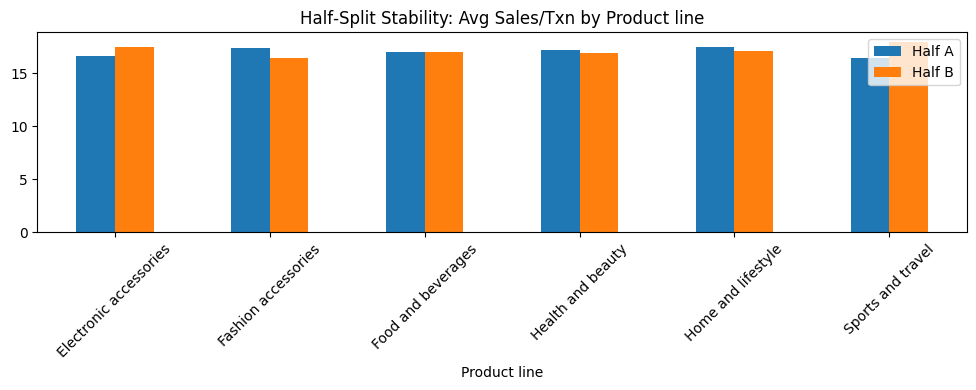

In [31]:
# V7) Random half-split stability
mask = np.random.default_rng(7).random(len(df)) < 0.5
a = df[mask]
b = df[~mask]
va = a.groupby('Product line')['Sales'].mean().rename('Half A')
vb = b.groupby('Product line')['Sales'].mean().rename('Half B')
stab = pd.concat([va,vb], axis=1)
display(stab)
stab.plot(kind='bar', figsize=(10,4), rot=45, title='Half‑Split Stability: Avg Sales/Txn by Product line')
plt.tight_layout(); plt.show()

## Extend Phase
### Gemini Prompt:
"Based on validated findings: **[summary]**, what specific business actions should executives take? Include timelines and ROI."

Provide the code to generate the below:


* **E1 – Offer–Audience Fit (Audience × Product line)**

  * Matrix: avg\_sales, avg\_gi, txns; plus heatmap(Avg GI/Txn Audience × Product line)
  * Plots: heatmap(Avg GI/Txn)

* **E2 – Category Action Grid (rule-based)**

  * Matrix: margin\_rate, avg\_rating, transactions, total\_sales, action (Promote / Improve CX / Price Optimize / Prune)
  * Plots: bar(Margin Rate by Product line), bar(Avg Rating by Product line)

* **E3 – Calendar Optimization (Day × Time × Product line)**

  * Matrix: total\_sales, txns; sorted Top-15 windows
  * Plots: bar(Top 15 Day×Time×Category by Sales)

* **E4 – Loyalty ROI (Member vs Normal)**

  * Matrix: lifts vs Normal (avg\_sales, avg\_gi, avg\_rating) + base metrics
  * Plots: bar(Avg Sales/Txn by Customer type), bar(Avg GI/Txn by Customer type), bar(Avg Rating by Customer type)

* **E5 – Branch Playbook Transfer**

  * Matrix: avg\_sales, avg\_gi, avg\_rating, transactions, total\_sales, gap\_vs\_best\_avg\_sales (City × Branch)
  * Plots: bar(Gap vs Best Avg Sales by Branch)

* **E6 – Payment Migration Opportunity**

  * Matrix: current\_expected\_avg\_sales, scenario\_expected\_avg\_sales, expected\_avg\_sales\_uplift (by segment)
  * Plots: bar(Expected Avg Sales Uplift if E-wallet at 90th percentile)

* **E7 – Capacity Planning Heatmap**

  * Matrix: transaction counts by Day\_of\_week × Time\_of\_day
  * Plots: heatmap(Transactions Day × Time)

* **E8 – Top Targets by Impact (Segment × Category)**

  * Matrix: impact\_score = avg\_gi × txns (Top-15)
  * Plots: (table output; optional bars if you choose)

#### E1) Offer–Audience Fit — Audience × Product line

,Customer type,Gender,Product line,avg_sales,avg_gi,txns
9,Member,Male,Health and beauty,18.094893,3.050826,3750
21,Normal,Male,Health and beauty,17.557957,3.035809,2794
2,Member,Female,Food and beverages,18.131706,3.033411,5600
0,Member,Female,Electronic accessories,17.304668,3.018311,5537
5,Member,Female,Sports and travel,18.332827,3.011778,5416
4,Member,Female,Home and lifestyle,17.974180,3.008712,5159
23,Normal,Male,Sports and travel,17.348508,3.008094,3065
10,Member,Male,Home and lifestyle,16.459291,3.006835,3929
13,Normal,Female,Fashion accessories,17.194632,2.994492,4352
18,Normal,Male,Electronic accessories,17.693333,2.992288,3287


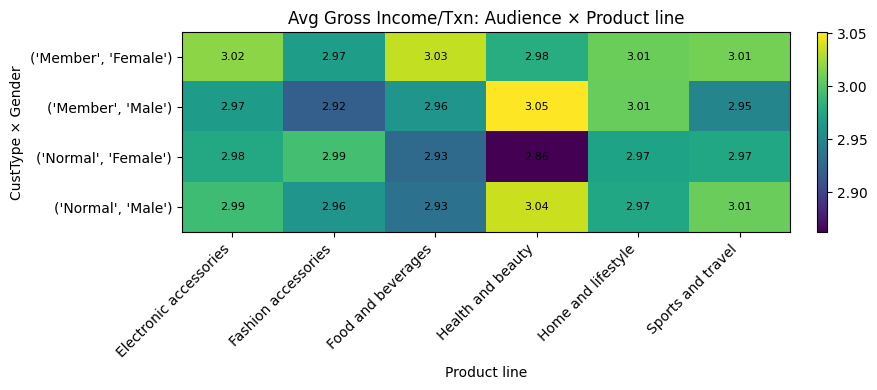

In [32]:
e1 = (df.groupby(['Customer type','Gender','Product line'])
        .agg(avg_sales=(COL_SALES,'mean'),
             avg_gi=(COL_GI,'mean'),
             txns=(COL_SALES,'size')).reset_index())
display(e1.sort_values(['avg_gi','txns'], ascending=[False,False]).head(25))
piv_gi = e1.pivot_table(index=['Customer type','Gender'], columns='Product line', values='avg_gi', fill_value=0)
heatmap_from_pivot(piv_gi, 'Avg Gross Income/Txn: Audience × Product line', 'Product line', 'CustType × Gender')

#### E2) Category Action Grid — Rule-based prioritization

,Product line,margin_rate,avg_rating,transactions,total_sales,action
0,Electronic accessories,0.175192,6.959868,17031,290714.454555,Improve CX
1,Fashion accessories,0.175333,6.969063,17712,299172.509168,Improve CX
2,Food and beverages,0.174540,6.975943,17439,296817.146897,Prune/Refactor
3,Health and beauty,0.174607,6.976229,15210,259430.306068,Promote
4,Home and lifestyle,0.173495,6.982321,16046,276797.980207,Price Optimize
5,Sports and travel,0.173585,6.998988,16562,284953.315229,Price Optimize


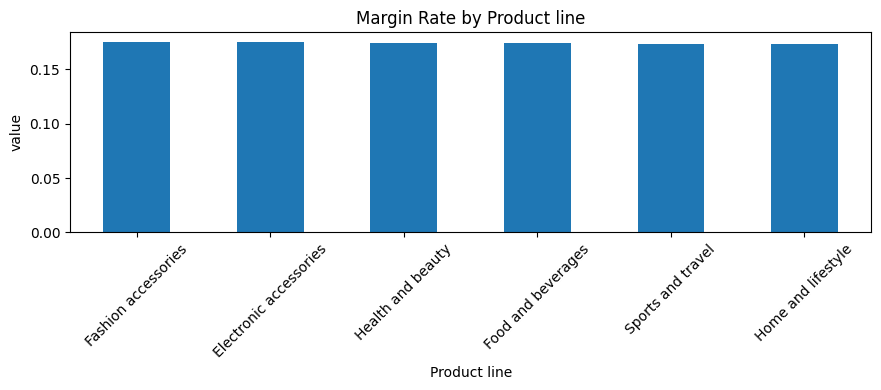

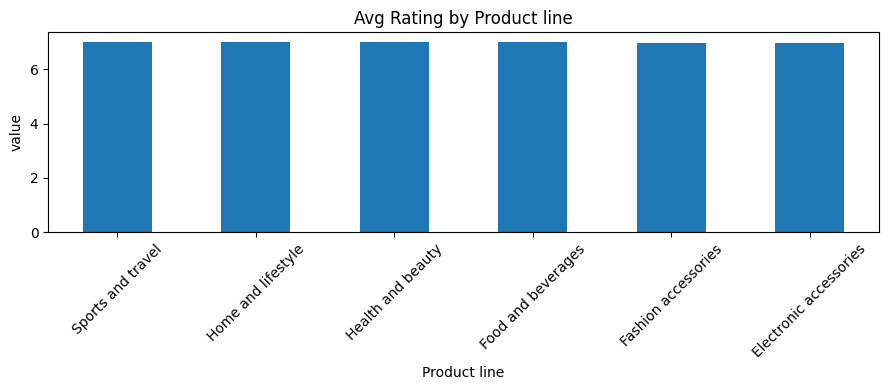

In [33]:
e2 = seg_metrics(df.groupby('Product line'))
e2['margin_rate'] = e2['total_gi'] / e2['total_sales']
mr_med = e2['margin_rate'].median()
rtg_med = e2['avg_rating'].median()

def rule(row):
    if row['margin_rate'] >= mr_med and row['avg_rating'] >= rtg_med: return 'Promote'
    if row['margin_rate'] >= mr_med and row['avg_rating'] <  rtg_med: return 'Improve CX'
    if row['margin_rate'] <  mr_med and row['avg_rating'] >= rtg_med: return 'Price Optimize'
    return 'Prune/Refactor'

e2['action'] = e2.apply(rule, axis=1)
display(e2[['Product line','margin_rate','avg_rating','transactions','total_sales','action']])
bar_from_series(e2.set_index('Product line')['margin_rate'], 'Margin Rate by Product line', 'Product line')
bar_from_series(e2.set_index('Product line')['avg_rating'], 'Avg Rating by Product line', 'Product line')

#### E3) Calendar Optimization — Top Day×Time×Category windows

,Day_of_week,Time_of_day,Product line,total_sales,txns
1,Friday,Afternoon,Fashion accessories,22139.503438,1199
72,Thursday,Afternoon,Electronic accessories,21083.823381,1153
37,Saturday,Afternoon,Fashion accessories,20983.655885,1099
110,Wednesday,Afternoon,Food and beverages,20779.541370,1156
90,Tuesday,Afternoon,Electronic accessories,20736.206043,1086
92,Tuesday,Afternoon,Food and beverages,20713.935525,1108
91,Tuesday,Afternoon,Fashion accessories,19829.132064,1176
113,Wednesday,Afternoon,Sports and travel,19708.766820,1085
77,Thursday,Afternoon,Sports and travel,19301.806930,1088
41,Saturday,Afternoon,Sports and travel,19252.234829,1066


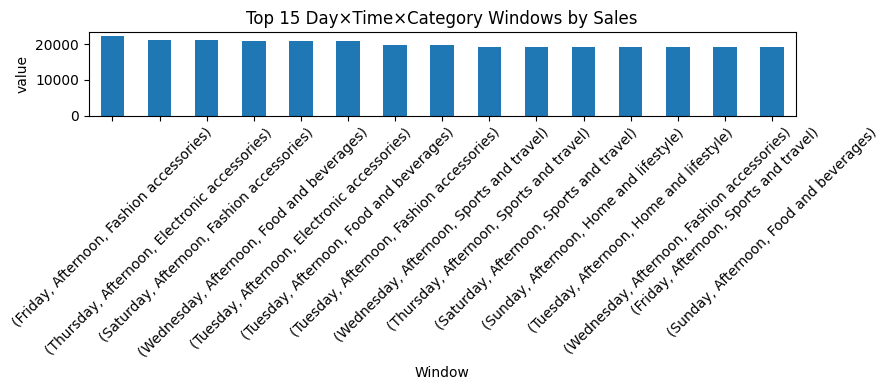

In [34]:
e3 = (df.groupby(['Day_of_week','Time_of_day','Product line'])
        .agg(total_sales=(COL_SALES,'sum'), txns=(COL_SALES,'size')).reset_index())
top = e3.sort_values('total_sales', ascending=False).head(15)
display(top)
bar_from_series(top.set_index(['Day_of_week','Time_of_day','Product line'])['total_sales'],
                'Top 15 Day×Time×Category Windows by Sales', 'Window')

#### E4) Loyalty ROI — Member vs Normal lifts

,Customer type,transactions,total_sales,avg_sales,total_gi,avg_gi,avg_rating,pct_high_value,lift_avg_sales_vs_Normal,lift_avg_gi_vs_Normal,lift_rating_vs_Normal
0,Member,56567,974213.978836,17.222302,169178.159056,2.990757,6.976800,0.201814,0.330268,0.025296,-0.000161
1,Normal,43433,733671.733288,16.892034,128798.891825,2.965462,6.976961,0.197638,0.000000,0.000000,0.000000


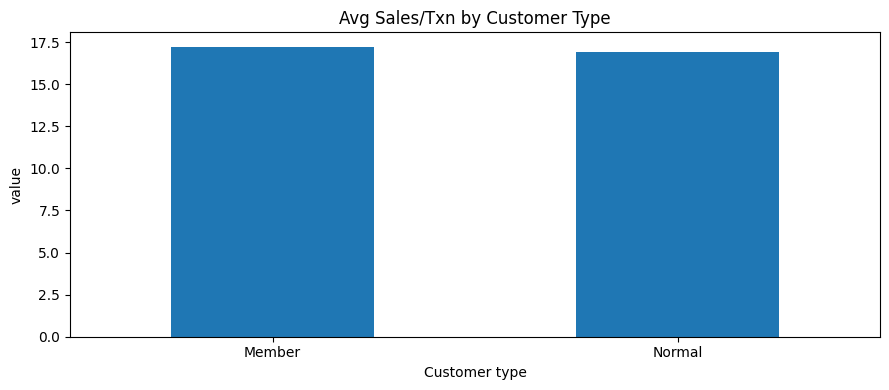

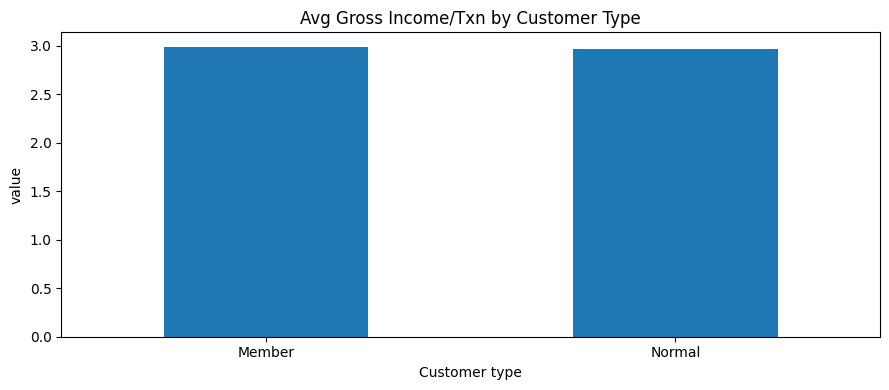

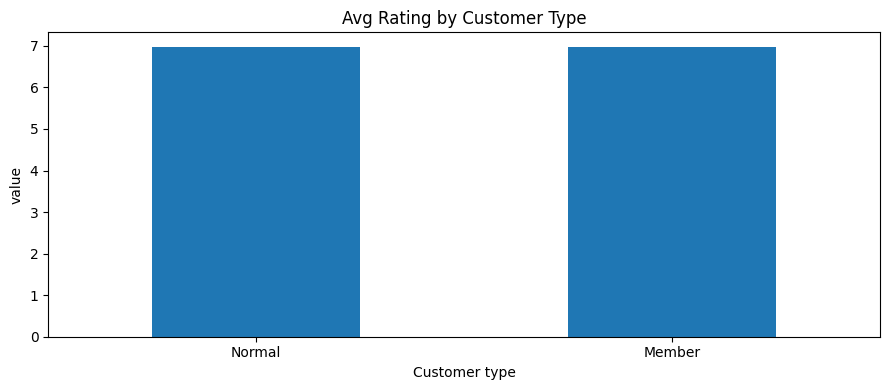

In [35]:
e4 = seg_metrics(df.groupby('Customer type'))
base = e4.set_index('Customer type').loc['Normal']
e4['lift_avg_sales_vs_Normal'] = e4['avg_sales'] - float(base['avg_sales'])
e4['lift_avg_gi_vs_Normal']    = e4['avg_gi']    - float(base['avg_gi'])
e4['lift_rating_vs_Normal']    = e4['avg_rating']- float(base['avg_rating'])
display(e4)
bar_from_series(e4.set_index('Customer type')['avg_sales'], 'Avg Sales/Txn by Customer Type', 'Customer type', rot=0)
bar_from_series(e4.set_index('Customer type')['avg_gi'], 'Avg Gross Income/Txn by Customer Type', 'Customer type', rot=0)
bar_from_series(e4.set_index('Customer type')['avg_rating'], 'Avg Rating by Customer Type', 'Customer type', rot=0)

#### E5) Branch Playbook Transfer — Gaps to best

,City,Branch,transactions,total_sales,avg_sales,total_gi,avg_gi,avg_rating,pct_high_value,gap_vs_best_avg_sales
5,Naypyitaw,Giza,10986,261139.492736,23.770207,35978.329129,3.274925,6.980992,0.218005,0.000000
1,Mandalay,Cairo,11208,257839.876594,23.004985,36057.449875,3.217117,6.969413,0.214757,0.765221
6,Yangon,Alex,11592,263192.976075,22.704708,36977.536822,3.189919,6.973233,0.213423,1.065499
3,Naypyitaw,Alex,11130,156896.346151,14.096707,32107.776177,2.884796,6.953231,0.198113,9.673500
4,Naypyitaw,Cairo,10761,151556.484706,14.083866,30856.214982,2.867411,6.984207,0.194870,9.686341
7,Yangon,Cairo,11251,157554.255274,14.003578,32128.867378,2.855645,6.988244,0.194649,9.766629
0,Mandalay,Alex,11191,155724.286482,13.915136,31848.616334,2.845913,6.994717,0.187293,9.855071
2,Mandalay,Giza,10757,149576.334070,13.905023,30487.029691,2.834157,6.967242,0.188993,9.865184
8,Yangon,Giza,11124,154405.660036,13.880408,31535.230493,2.834882,6.980511,0.189051,9.889799


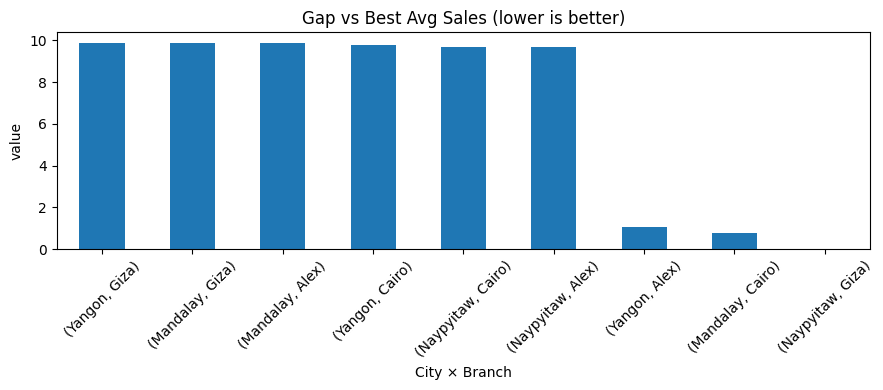

In [36]:
e5 = seg_metrics(df.groupby(['City','Branch']))
leader_avg_sales = e5['avg_sales'].max()
e5['gap_vs_best_avg_sales'] = leader_avg_sales - e5['avg_sales']
display(e5.sort_values('gap_vs_best_avg_sales'))
bar_from_series(e5.set_index(['City','Branch'])['gap_vs_best_avg_sales'], 'Gap vs Best Avg Sales (lower is better)', 'City × Branch')

#### E6) Payment Migration Opportunity
**Gemini Prompt:**
> For each **Customer type × Gender** segment, estimate **sales uplift** if **E‑wallet share** rose to the 90th percentile of that segment across cities.
> Compute current weighted Avg Sales by payment in the segment and compare with the scenario.

current_expected_avg_sales  scenario_expected_avg_sales  \
Customer type Gender                                                            
Normal        Male                     17.217777                    17.221161   
              Female                   16.644451                    16.644652   
Member        Male                     16.634058                    16.633646   
              Female                   17.661706                    17.661042   

                      expected_avg_sales_uplift  
Customer type Gender                             
Normal        Male                     0.003384  
              Female                   0.000201  
Member        Male                    -0.000412  
              Female                  -0.000664

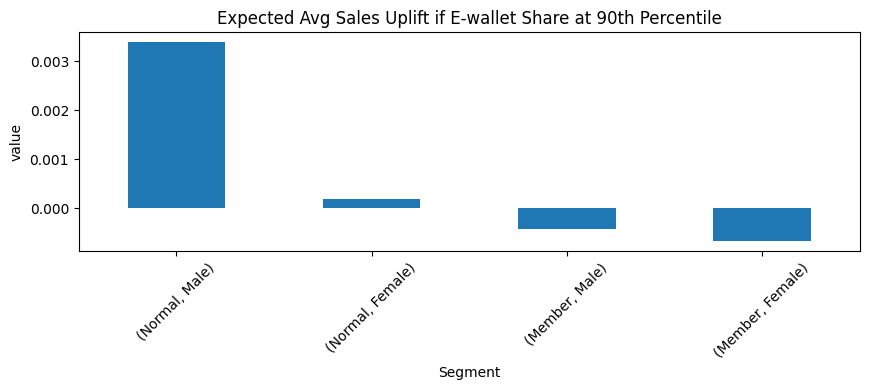

In [37]:
# E6) Payment Migration Opportunity Matrix
seg_pay = (df.groupby(['Customer type','Gender','Payment'])
            .agg(txns=('Sales','size'), avg_sales=('Sales','mean'))
            .reset_index())
mix = seg_pay.pivot_table(index=['Customer type','Gender'], columns='Payment', values='txns', fill_value=0)
mix = mix.div(mix.sum(axis=1), axis=0).fillna(0)
avg_by_pay = seg_pay.pivot_table(index=['Customer type','Gender'], columns='Payment', values='avg_sales', fill_value=0)
current_avg = (mix * avg_by_pay).sum(axis=1).rename('current_expected_avg_sales')
seg_city_ew = (df.assign(is_ew=df['Payment'].eq('Ewallet').astype(int))
                 .groupby(['Customer type','Gender','City'])['is_ew']
                 .mean().rename('ew_share').reset_index())
target_ew = seg_city_ew.groupby(['Customer type','Gender'])['ew_share'].quantile(0.90).rename('target_ew_share')
common_idx = mix.index.intersection(target_ew.index)
scenario = mix.loc[common_idx].copy()
scenario['Ewallet'] = target_ew
other_cols = [c for c in scenario.columns if c != 'Ewallet']
rem = 1 - scenario['Ewallet']
sum_others = scenario[other_cols].sum(axis=1).replace(0,1)
for c in other_cols:
    scenario[c] = scenario[c] * rem / sum_others
scenario_avg = (scenario.reindex(columns=avg_by_pay.columns, fill_value=0) * avg_by_pay.loc[common_idx]).sum(axis=1)
uplift = (scenario_avg - current_avg.loc[common_idx]).rename('expected_avg_sales_uplift')
e6 = pd.concat([current_avg.loc[common_idx], scenario_avg.rename('scenario_expected_avg_sales'), uplift], axis=1)
display(e6.sort_values('expected_avg_sales_uplift', ascending=False))
bar_from_series(e6['expected_avg_sales_uplift'], 'Expected Avg Sales Uplift if E-wallet Share at 90th Percentile', 'Segment')

#### E7) Capacity Planning Heatmap — Transactions Day × Time
**Gemini Prompt:**
> Build a **Day_of_week × Time_of_day** heatmap of **transaction counts** to guide staffing and checkout capacity planning.

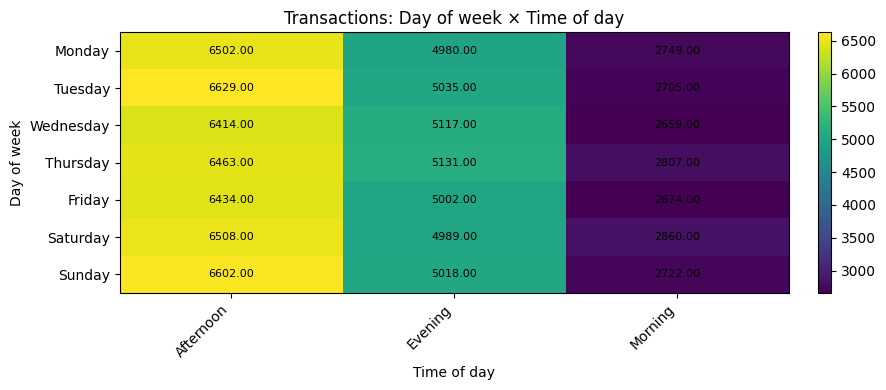

In [38]:
# E7) Capacity planning heatmap (transaction counts)
e7 = df.pivot_table(index='Day_of_week', columns='Time_of_day', values='Sales', aggfunc='size').fillna(0)
order = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
e7 = e7.reindex(order)
heatmap_from_pivot(e7, 'Transactions: Day of week × Time of day', 'Time of day', 'Day of week')

#### E8) Top Targets by Impact — Segment × Category
**Gemini Prompt:**
> Create a ranked **Segment × Category** table where **Impact Score = Avg GI/Txn × Transactions**.
> Return the top‑15 cells to prioritize for marketing and merchandising actions.

In [39]:
# E8) Top targets by impact
e8 = (df.groupby(['Customer type','Gender','Product line'])
        .agg(txns=('Sales','size'), avg_gi=('gross income','mean'))
        .reset_index())
e8['impact_score'] = e8['avg_gi'] * e8['txns']
display(e8.sort_values('impact_score', ascending=False).head(15))

,Customer type,Gender,Product line,txns,avg_gi,impact_score
1,Member,Female,Fashion accessories,5789,2.968202,17182.922086
2,Member,Female,Food and beverages,5600,3.033411,16987.101998
0,Member,Female,Electronic accessories,5537,3.018311,16712.389198
5,Member,Female,Sports and travel,5416,3.011778,16311.790594
4,Member,Female,Home and lifestyle,5159,3.008712,15521.946872
3,Member,Female,Health and beauty,4879,2.979382,14536.407061
13,Normal,Female,Fashion accessories,4352,2.994492,13032.029371
14,Normal,Female,Food and beverages,4324,2.927724,12659.480292
8,Member,Male,Food and beverages,4201,2.960838,12438.480199
7,Member,Male,Fashion accessories,4237,2.919261,12368.909504
